# French Renewable Energy Data Pre-Processing

### Generation Data

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.constants import convert_temperature
import plotly.express as px

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout
from math import sqrt

from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [2]:
France_Renewable = pd.read_csv("/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Generation/Europe_Renewables.csv",
                   usecols=(lambda s: s.startswith('utc') | s.startswith('FR')),
                    parse_dates=[0], index_col=0)    

In [3]:
France_Renewable.head()

FR_load_actual_entsoe_power_statistics  \
utc_timestamp                                                       
2004-12-31 23:00:00+00:00                                     NaN   
2005-01-01 00:00:00+00:00                                     NaN   
2005-01-01 01:00:00+00:00                                     NaN   
2005-01-01 02:00:00+00:00                                     NaN   
2005-01-01 03:00:00+00:00                                     NaN   

                           FR_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2004-12-31 23:00:00+00:00                                 NaN   
2005-01-01 00:00:00+00:00                                 NaN   
2005-01-01 01:00:00+00:00                                 NaN   
2005-01-01 02:00:00+00:00                                 NaN   
2005-01-01 03:00:00+00:00                                 NaN   

                           FR_load_actual_tso  \
utc_timestamp                                   
2004-12-31 23:00:00+00:00                 NaN   
2005-01-01 00:00:00+00:00                 NaN   
2005-01-01 01:00:00+00:00                 NaN   
2005-01-01 02:00:00+00:00                 NaN   
2005-01-01 03:00:00+00:00                 NaN   

                           FR_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2004-12-31 23:00:00+00:00                                   NaN   
2005-01-01 00:00:00+00:00                                   NaN   
2005-01-01 01:00:00+00:00                                   NaN   
2005-01-01 02:00:00+00:00                                   NaN   
2005-01-01 03:00:00+00:00                                   NaN   

                           FR_load_forecast_tso  FR_solar_generation_actual  \
utc_timestamp                                                                 
2004-12-31 23:00:00+00:00                   NaN                         NaN   
2005-01-01 00:00:00+00:00                   NaN                         NaN   
2005-01-01 01:00:00+00:00                   NaN                         NaN   
2005-01-01 02:00:00+00:00                   NaN                         NaN   
2005-01-01 03:00:00+00:00                   NaN                         NaN   

                           FR_wind_onshore_generation_actual  
utc_timestamp                                                 
2004-12-31 23:00:00+00:00                                NaN  
2005-01-01 00:00:00+00:00                                NaN  
2005-01-01 01:00:00+00:00                                NaN  
2005-01-01 02:00:00+00:00                                NaN  
2005-01-01 03:00:00+00:00                                NaN

In [4]:
def clean_renewable_data(data):

    data['Index'] = data.reset_index(inplace=True)
    data['Index'] = range(1, len(data) + 1)
    data = France_Renewable[['utc_timestamp', 'FR_solar_generation_actual', 'FR_wind_onshore_generation_actual']]
    data = data.rename(columns={"FR_solar_generation_actual": "Solar KwH"})
    data = data.rename(columns={"FR_wind_onshore_generation_actual": "Wind KwH"})
    data = data.rename(columns={"utc_timestamp": "Date"})
    data['Total'] = data['Solar KwH'] + data['Wind KwH']
    data = data.round(2)
    data = data.fillna(0)

    return data 

France_Renewable = clean_renewable_data(France_Renewable)

In [5]:
France_Renewable.head()

Date  Solar KwH  Wind KwH  Total
0 2004-12-31 23:00:00+00:00        0.0       0.0    0.0
1 2005-01-01 00:00:00+00:00        0.0       0.0    0.0
2 2005-01-01 01:00:00+00:00        0.0       0.0    0.0
3 2005-01-01 02:00:00+00:00        0.0       0.0    0.0
4 2005-01-01 03:00:00+00:00        0.0       0.0    0.0

In [6]:
def date_limits(data):

    data['Date'] = data['Date'].astype('datetime64[ns]')
    start_date = '01-01-2016'
    end_date = '12-31-2016'
    mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
    data = data.loc[mask]
    data.reset_index(inplace=True)
    
    return data

France_Renewable = date_limits(France_Renewable)    
France_Renewable.head()

index                Date  Solar KwH  Wind KwH   Total
0  96409 2016-01-01 00:00:00       -1.0    2082.0  2081.0
1  96410 2016-01-01 01:00:00       -1.0    1690.0  1689.0
2  96411 2016-01-01 02:00:00       -1.0    1414.0  1413.0
3  96412 2016-01-01 03:00:00       -1.0    1200.0  1199.0
4  96413 2016-01-01 04:00:00       -1.0    1000.0   999.0

### Weather Data

In [7]:
France_weather = pd.read_csv("/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Generation/FranceWeather.csv", low_memory = False)

In [8]:
France_weather.head()

# Date UT time  Temperature  Relative Humidity  Pressure  Wind speed  \
0  2016-01-01   01:00       282.79              83.61   1005.81        2.13   
1  2016-01-01   02:00       282.57              83.98   1005.48        2.24   
2  2016-01-01   03:00       282.30              84.26   1005.28        2.35   
3  2016-01-01   04:00       281.98              84.72   1005.16        2.46   
4  2016-01-01   05:00       281.70              85.30   1005.12        2.69   

   Wind direction  Rainfall  Snowfall  Snow depth Short-wave irradiation  
0           89.96  0.013449       0.0         0.0                 0.0000  
1           79.76  0.005852       0.0         0.0                 0.0000  
2           69.75  0.005272       0.0         0.0                 0.0000  
3           59.75  0.008434       0.0         0.0                 0.0000  
4           55.55  0.009532       0.0         0.0                 0.0000

In [9]:
def clean_weather_data(data):
    
    data = data.rename(columns={"# Date": "Date"})
    data['Date'] = data['Date']  + ' ' + data['UT time']
    data['Date'] = data['Date'].str.replace(r'\b24:00\b', '00:00')
    data['Date'] = data['Date'].astype('datetime64[ns]')
    
    data = data.groupby(data.Date).mean()
    data.reset_index(inplace=True)

    return data 

France_weather = clean_weather_data(France_weather)

In [10]:
France_weather.head()

Date  Temperature  Relative Humidity     Pressure  \
0 2016-01-01 00:00:00   279.844167          92.480000   982.646667   
1 2016-01-01 01:00:00   282.790000          83.610000  1005.810000   
2 2016-01-01 02:00:00   278.203333          96.711667   994.886667   
3 2016-01-01 03:00:00   278.110833          96.420833   994.885833   
4 2016-01-01 04:00:00   278.080833          95.588333   994.741667   

   Wind speed  Wind direction  Rainfall  Snowfall    Snow depth  
0    5.700000      155.613333  0.453094  0.000380  3.000000e-06  
1    2.130000       89.960000  0.013449  0.000000  0.000000e+00  
2    2.305833      170.605000  0.011153  0.000019  5.833333e-07  
3    2.289167      171.334167  0.010858  0.000022  5.833333e-07  
4    2.338333      168.735000  0.013468  0.000023  6.666667e-07

In [11]:
print(len(France_weather))

8784


In [12]:
France_weather_2 = pd.read_csv("/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Generation/FranceWeather2.csv",
                                parse_dates=[0], index_col=0)    

In [13]:
France_weather_2.head()

FR_windspeed_10m  FR_temperature  \
utc_timestamp                                                 
2016-01-01 00:00:00+00:00              2.86           5.571   
2016-01-01 01:00:00+00:00              2.68           5.415   
2016-01-01 02:00:00+00:00              2.51           5.288   
2016-01-01 03:00:00+00:00              2.45           5.177   
2016-01-01 04:00:00+00:00              2.35           5.131   

                           FR_radiation_direct_horizontal  \
utc_timestamp                                               
2016-01-01 00:00:00+00:00                             0.0   
2016-01-01 01:00:00+00:00                             0.0   
2016-01-01 02:00:00+00:00                             0.0   
2016-01-01 03:00:00+00:00                             0.0   
2016-01-01 04:00:00+00:00                             0.0   

                           FR_radiation_diffuse_horizontal  
utc_timestamp                                               
2016-01-01 00:00:00+00:00                              0.0  
2016-01-01 01:00:00+00:00                              0.0  
2016-01-01 02:00:00+00:00                              0.0  
2016-01-01 03:00:00+00:00                              0.0  
2016-01-01 04:00:00+00:00                              0.0

In [14]:
def clean_weather_2(data): 

    data.reset_index(inplace=True)
    data.columns = data.columns.str.replace(r'(^.*windspeed_.*$)', 'Wind Velocity (10m)')
    data.columns = data.columns.str.replace(r'(^.*direct.*$)', 'Atmospheric Horizontal Radiation')
    data.columns = data.columns.str.replace(r'(^.*diffuse.*$)', 'Atmospheric Ground Radiation')
    data = data.rename(columns={"utc_timestamp": "Date"})
    data = data.drop(['FR_temperature'], axis=1)
    
    data['Date'] = data['Date'].astype('datetime64[ns]')
    data ['Date'] = data['Date'].astype('datetime64')
    data ['Month'] = data['Date'].dt.month
    data ['Day'] = data['Date'].dt.dayofweek
    data ['Hour'] = data['Date'].dt.hour
    data.reset_index(inplace=True)
        
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    month_to_season = dict(zip(range(1,13), seasons))
    data['Season'] = data.Month.map(month_to_season)
    
    return data

France_weather_2 = clean_weather_2(France_weather_2)

In [15]:
France_weather_2.head()

index                Date  Wind Velocity (10m)  \
0      0 2016-01-01 00:00:00                 2.86   
1      1 2016-01-01 01:00:00                 2.68   
2      2 2016-01-01 02:00:00                 2.51   
3      3 2016-01-01 03:00:00                 2.45   
4      4 2016-01-01 04:00:00                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0      1    4   
1                               0.0                           0.0      1    4   
2                               0.0                           0.0      1    4   
3                               0.0                           0.0      1    4   
4                               0.0                           0.0      1    4   

   Hour  Season  
0     0       1  
1     1       1  
2     2       1  
3     3       1  
4     4       1

In [16]:
France_Renewable = France_Renewable[France_Renewable.index < 8760]
France_weather = France_weather[France_weather.index < 8760]
France_weather_2 = France_weather_2[France_weather_2.index < 8760]

In [17]:
def merge(Weather, Weather_2, Generation):
    
    Merge = pd.merge(Weather, Weather_2, on= "Date", how="left")
    Country = pd.merge(Generation, Merge , on = "Date", how = "left")
    Country = Country.dropna()
    Country = Country.drop(['index_x', 'index_y'], axis=1)
    Country = Country.round(2)
    
    return Country

France = merge(France_weather, France_weather_2, France_Renewable)

In [18]:
France.head()

Date  Solar KwH  Wind KwH   Total  Temperature  \
0 2016-01-01 00:00:00       -1.0    2082.0  2081.0       279.84   
1 2016-01-01 01:00:00       -1.0    1690.0  1689.0       282.79   
2 2016-01-01 02:00:00       -1.0    1414.0  1413.0       278.20   
3 2016-01-01 03:00:00       -1.0    1200.0  1199.0       278.11   
4 2016-01-01 04:00:00       -1.0    1000.0   999.0       278.08   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              92.48    982.65        5.70          155.61      0.45   
1              83.61   1005.81        2.13           89.96      0.01   
2              96.71    994.89        2.31          170.60      0.01   
3              96.42    994.89        2.29          171.33      0.01   
4              95.59    994.74        2.34          168.74      0.01   

   Snowfall  Snow depth  Wind Velocity (10m)  \
0       0.0         0.0                 2.86   
1       0.0         0.0                 2.68   
2       0.0         0.0                 2.51   
3       0.0         0.0                 2.45   
4       0.0         0.0                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0    1.0  4.0   
1                               0.0                           0.0    1.0  4.0   
2                               0.0                           0.0    1.0  4.0   
3                               0.0                           0.0    1.0  4.0   
4                               0.0                           0.0    1.0  4.0   

   Hour  Season  
0   0.0     1.0  
1   1.0     1.0  
2   2.0     1.0  
3   3.0     1.0  
4   4.0     1.0

In [19]:
France.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8760
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              8760 non-null   datetime64[ns]
 1   Solar KwH                         8760 non-null   float64       
 2   Wind KwH                          8760 non-null   float64       
 3   Total                             8760 non-null   float64       
 4   Temperature                       8760 non-null   float64       
 5   Relative Humidity                 8760 non-null   float64       
 6   Pressure                          8760 non-null   float64       
 7   Wind speed                        8760 non-null   float64       
 8   Wind direction                    8760 non-null   float64       
 9   Rainfall                          8760 non-null   float64       
 10  Snowfall                          8760 non-null 

In [20]:
France.describe().round(2)

Solar KwH  Wind KwH     Total  Temperature  Relative Humidity  \
count    8760.00   8760.00   8760.00      8760.00            8760.00   
mean      941.91   2386.47   3328.38       284.82              78.77   
std      1325.88   1792.78   2049.24         7.03              14.46   
min        -2.00     53.00    108.00       270.77              37.16   
25%        -1.00   1065.75   1639.75       279.30              68.34   
50%        27.00   1846.00   2942.00       283.88              83.54   
75%      1772.00   3214.50   4675.50       290.03              90.79   
max      5213.00   8620.00  10833.00       305.22             100.60   

       Pressure  Wind speed  Wind direction  Rainfall  Snowfall  Snow depth  \
count   8760.00     8760.00         8760.00   8760.00   8760.00     8760.00   
mean     987.78        3.81          198.62      0.11      0.00        0.00   
std        7.97        1.40           63.69      0.18      0.02        0.00   
min      960.14        1.11           37.55      0.00      0.00        0.00   
25%      983.12        2.79          144.94      0.01      0.00        0.00   
50%      988.45        3.46          202.00      0.04      0.00        0.00   
75%      992.79        4.52          251.46      0.14      0.00        0.00   
max     1009.91       11.01          332.94      1.79      0.37        0.02   

       Wind Velocity (10m)  Atmospheric Horizontal Radiation  \
count              8760.00                           8760.00   
mean                  4.05                             90.21   
std                   1.53                            165.10   
min                   1.36                              0.00   
25%                   2.96                              0.00   
50%                   3.67                              0.74   
75%                   4.84                            100.07   
max                  12.15                            838.32   

       Atmospheric Ground Radiation    Month     Day     Hour   Season  
count                       8760.00  8760.00  8760.0  8760.00  8760.00  
mean                          72.05     6.50     3.0    11.50     2.50  
std                           93.97     3.44     2.0     6.92     1.11  
min                            0.00     1.00     0.0     0.00     1.00  
25%                            0.00     4.00     1.0     5.75     2.00  
50%                            8.40     7.00     3.0    11.50     3.00  
75%                          131.81     9.00     5.0    17.25     3.00  
max                          398.21    12.00     6.0    23.00     4.00

In [21]:
France.to_csv(r'/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Generation/France_Renewable_Processed.csv', index = False)

In [22]:
France.head()

Date  Solar KwH  Wind KwH   Total  Temperature  \
0 2016-01-01 00:00:00       -1.0    2082.0  2081.0       279.84   
1 2016-01-01 01:00:00       -1.0    1690.0  1689.0       282.79   
2 2016-01-01 02:00:00       -1.0    1414.0  1413.0       278.20   
3 2016-01-01 03:00:00       -1.0    1200.0  1199.0       278.11   
4 2016-01-01 04:00:00       -1.0    1000.0   999.0       278.08   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              92.48    982.65        5.70          155.61      0.45   
1              83.61   1005.81        2.13           89.96      0.01   
2              96.71    994.89        2.31          170.60      0.01   
3              96.42    994.89        2.29          171.33      0.01   
4              95.59    994.74        2.34          168.74      0.01   

   Snowfall  Snow depth  Wind Velocity (10m)  \
0       0.0         0.0                 2.86   
1       0.0         0.0                 2.68   
2       0.0         0.0                 2.51   
3       0.0         0.0                 2.45   
4       0.0         0.0                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0    1.0  4.0   
1                               0.0                           0.0    1.0  4.0   
2                               0.0                           0.0    1.0  4.0   
3                               0.0                           0.0    1.0  4.0   
4                               0.0                           0.0    1.0  4.0   

   Hour  Season  
0   0.0     1.0  
1   1.0     1.0  
2   2.0     1.0  
3   3.0     1.0  
4   4.0     1.0

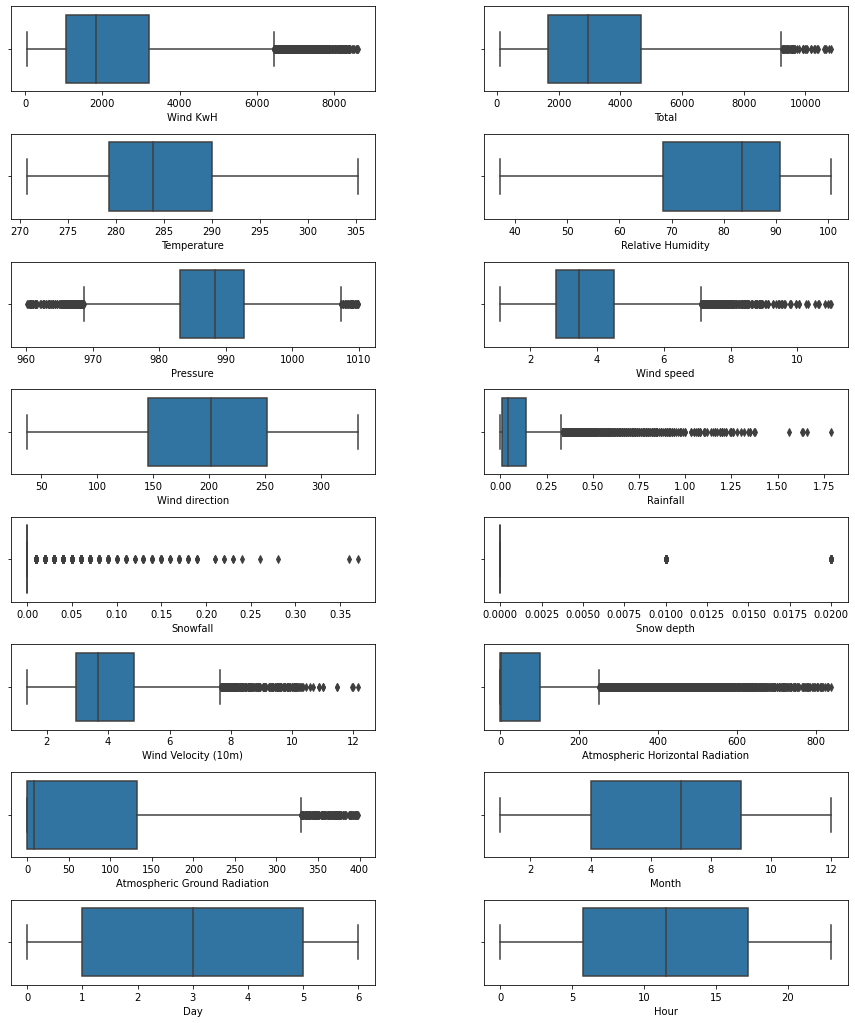

In [23]:
fig, axes = plt.subplots(ncols = 2, nrows = 8, figsize = (15,18))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax, col in zip(axes.flatten(), France.columns[2:]):
    sns.boxplot(x = France[col], ax = ax)

In [24]:
def plot_series(df=None, column=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):
  
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Date', fontsize=16)
    
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if label:
        ax.legend(fontsize=16)
        
    if title:
        ax.set_title(title, fontsize=24)
        
    ax.grid(True)
    return ax

/Users/chris/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


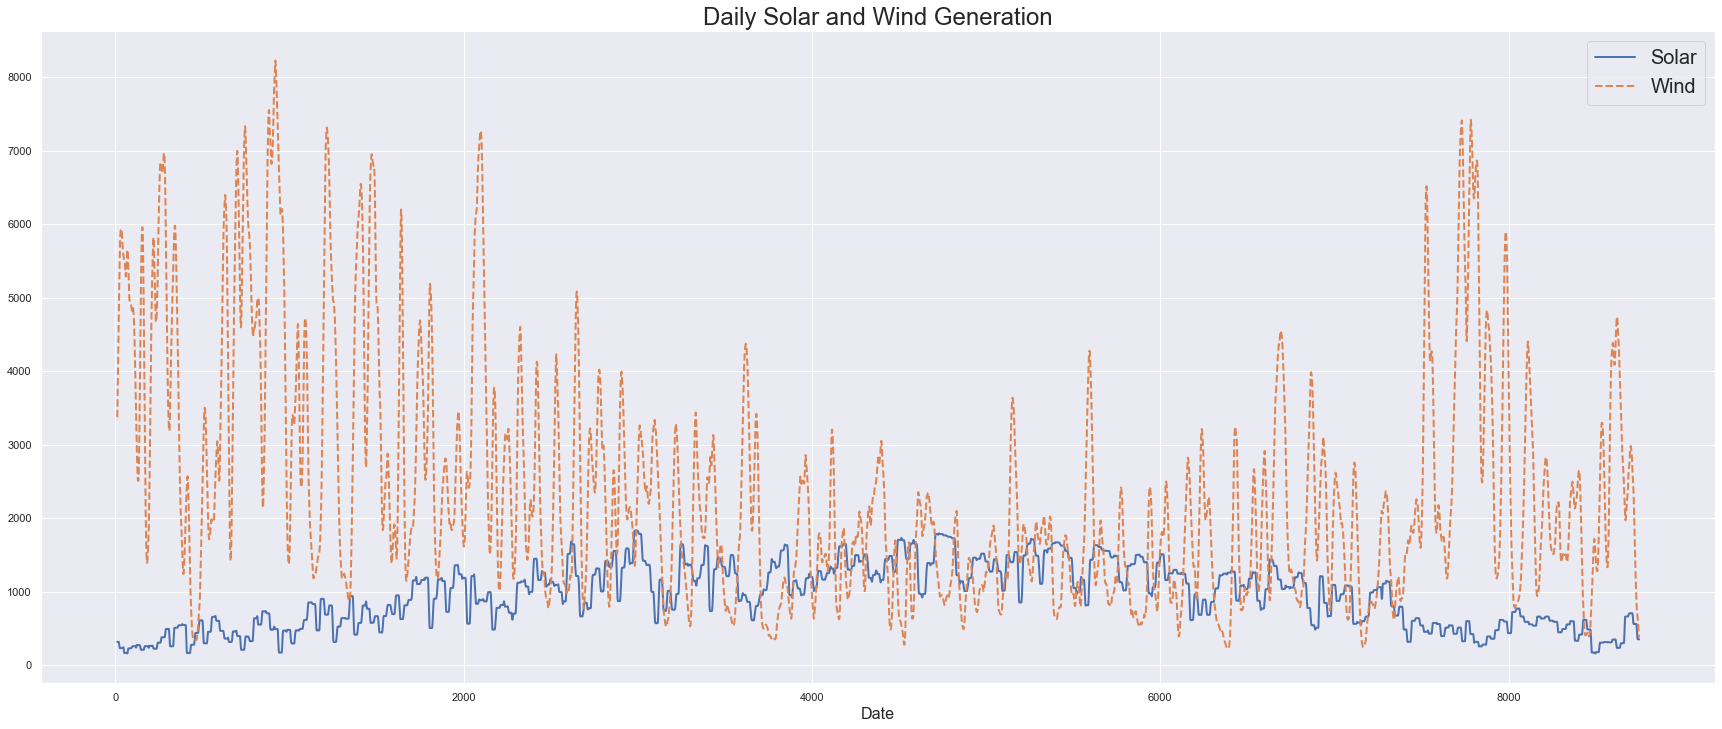

In [25]:
import datetime

Solar_daily = France['Solar KwH'].rolling(24, center= True).mean()
Wind_daily = France['Wind KwH'].rolling(24, center= True).mean()

ax = plot_series(title='Daily Solar and Wind Generation')

ax.plot(Solar_daily, linestyle='-', linewidth=2, label='Solar')
ax.plot(Wind_daily, linestyle='--', linewidth=2, label='Wind')
ax.legend(prop={'size': 20})

plt.show()

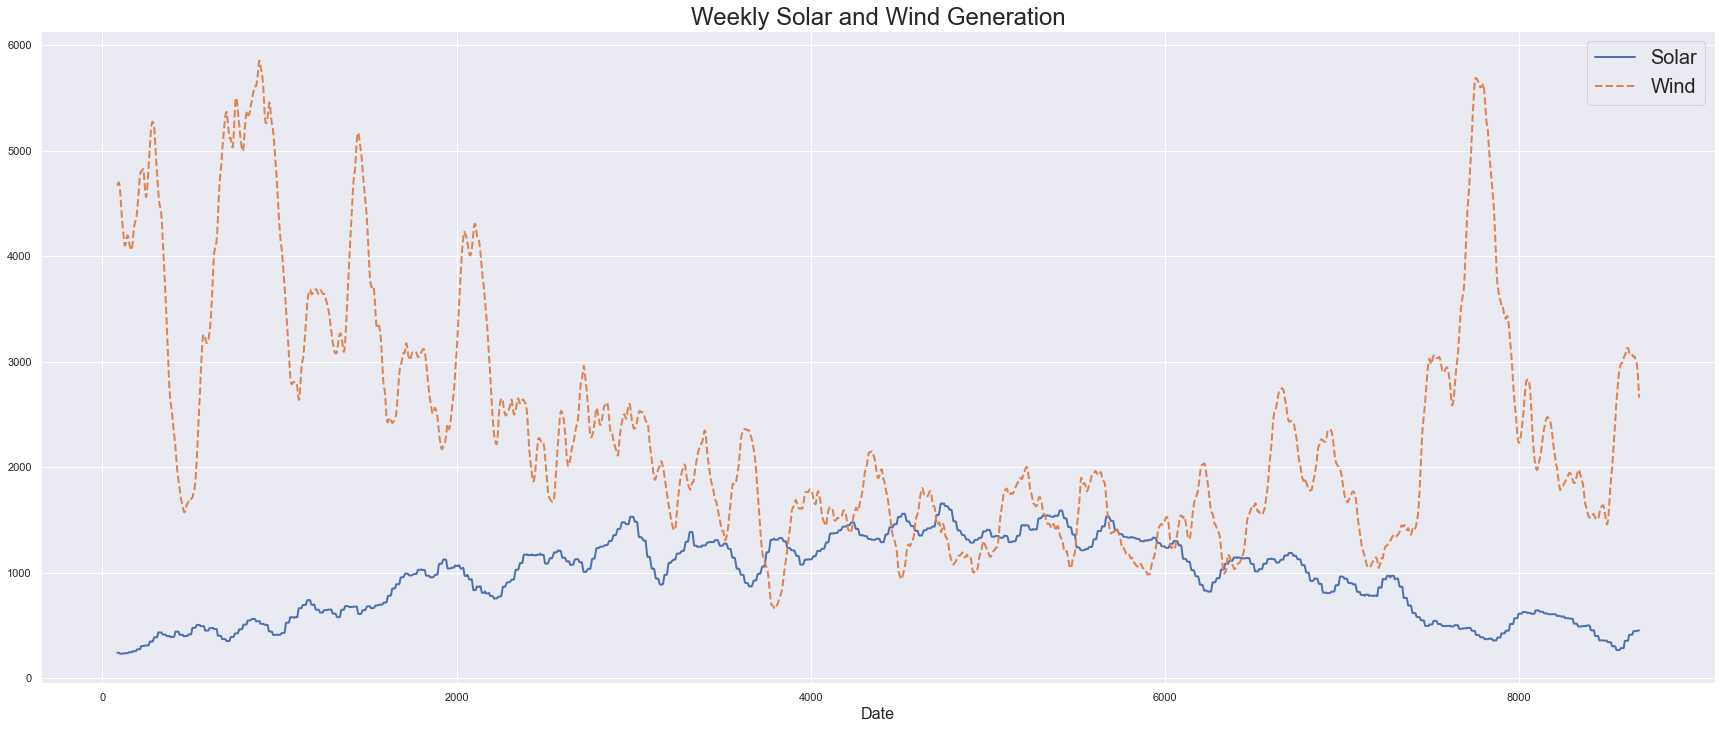

In [26]:
Solar_weekly = France['Solar KwH'].rolling(24*7, center= True).mean()
Wind_weekly = France['Wind KwH'].rolling(24*7, center= True).mean()

ax = plot_series(title='Weekly Solar and Wind Generation')

ax.plot(Solar_weekly, linestyle='-', linewidth=2, label='Solar')
ax.plot(Wind_weekly, linestyle='--', linewidth=2, label='Wind')
ax.legend(prop={'size': 20})

plt.show()

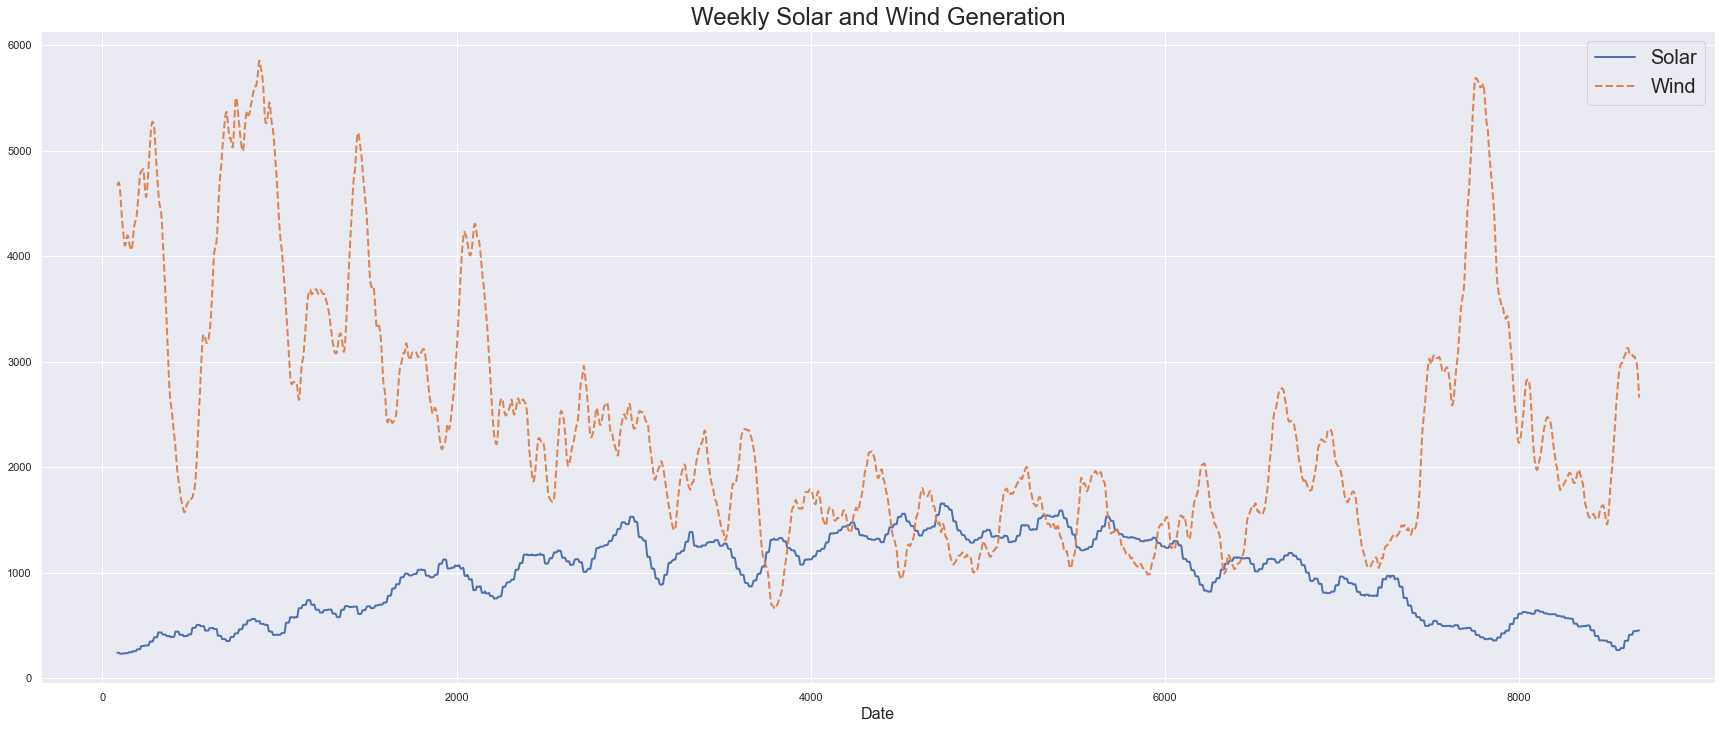

In [27]:
Solar_monthly = France['Solar KwH'].rolling(24*30, center= True).mean()
Wind_monthly = France['Wind KwH'].rolling(24*30, center= True).mean()

ax = plot_series(title='Weekly Solar and Wind Generation')

ax.plot(Solar_weekly, linestyle='-', linewidth=2, label='Solar')
ax.plot(Wind_weekly, linestyle='--', linewidth=2, label='Wind')
ax.legend(prop={'size': 20})

plt.show()

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(France['Solar KwH'], lags=50, ax=ax1)
plot_pacf(France['Solar KwH'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(France['Wind KwH'], lags=50, ax=ax1)
plot_pacf(France['Wind KwH'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [30]:
correlations = France.corr(method='pearson')
fig = plt.figure(figsize=(15, 15))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [31]:
Solar_Wind_Ratio = (France['Solar KwH'].sum() / (France['Total'].sum())).round(2)
print(Solar_Wind_Ratio)

0.28


In [32]:
renewable_agg = France.groupby(['Month'], as_index=False, sort=False)['Total'].sum()
solar_agg = France.groupby(['Month'], as_index=False, sort=False)['Solar KwH'].sum()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Wind KwH', x = renewable_agg['Month'], y= renewable_agg['Total']),
    go.Bar(name='Solar KwH', x = solar_agg['Month'], y= solar_agg['Solar KwH'])
])

fig.update_layout(barmode='stack')
fig.show()

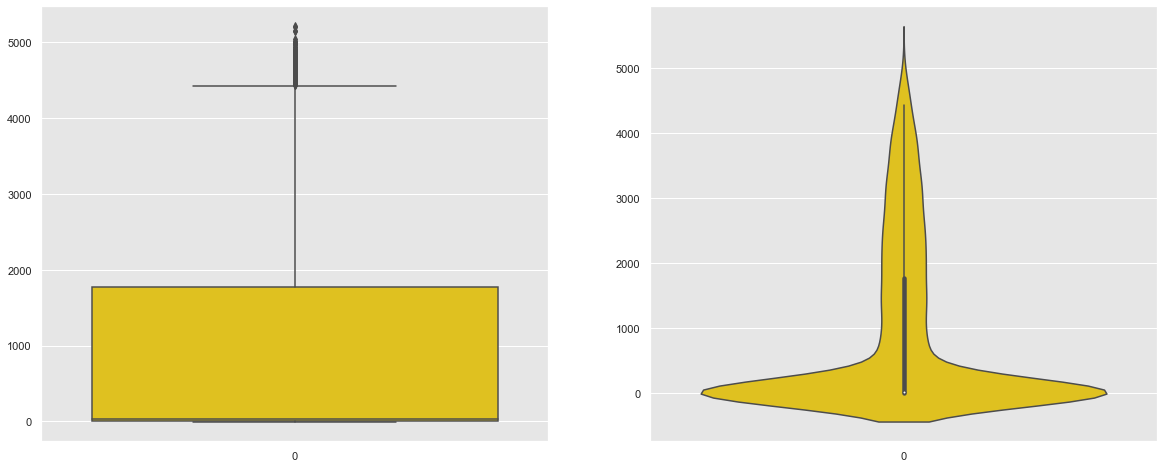

In [33]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

x = France['Solar KwH']
sns.axes_style("darkgrid")

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data = x, color = 'Gold')

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data = x, color = 'Gold',)

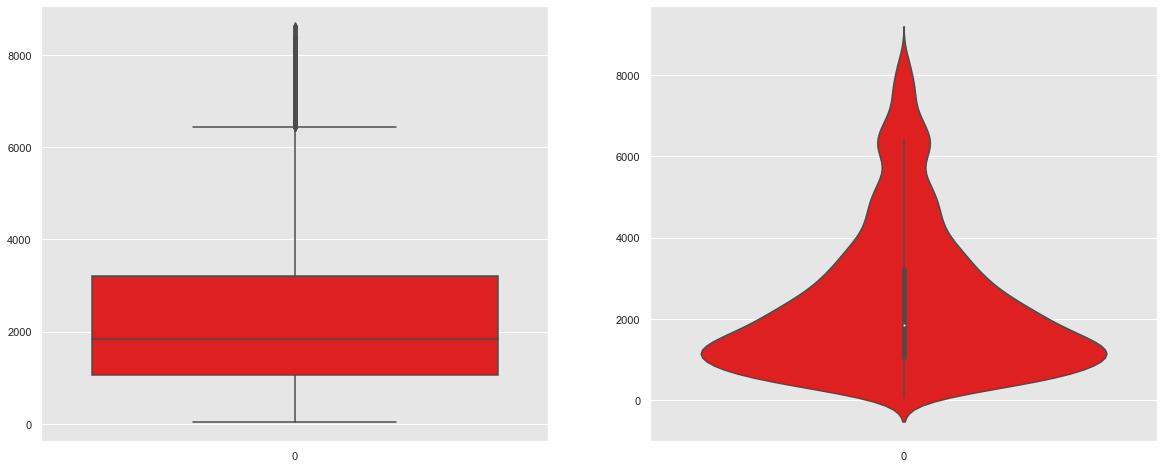

In [34]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

x = France['Wind KwH']
sns.axes_style("darkgrid")

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data = x, color = 'Red')

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data = x, color = 'Red',)

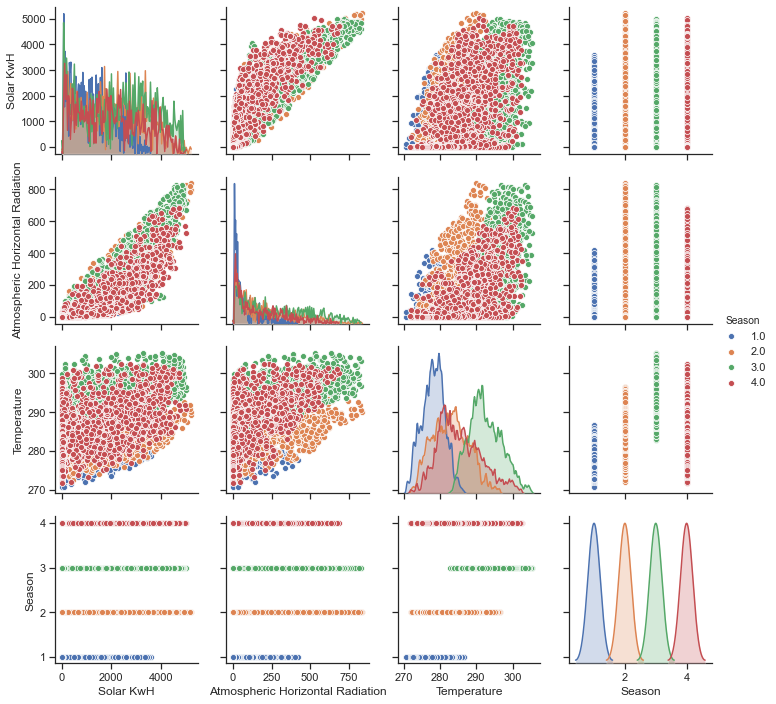

In [39]:
cols = ['Solar KwH', 'Atmospheric Horizontal Radiation', 'Temperature', 'Season']

scatter_df = France[cols]

sns.set(style="ticks")

df = scatter_df
sns.pairplot(df, hue = "Season", diag_kws={'bw': 0.2})
plt.show()

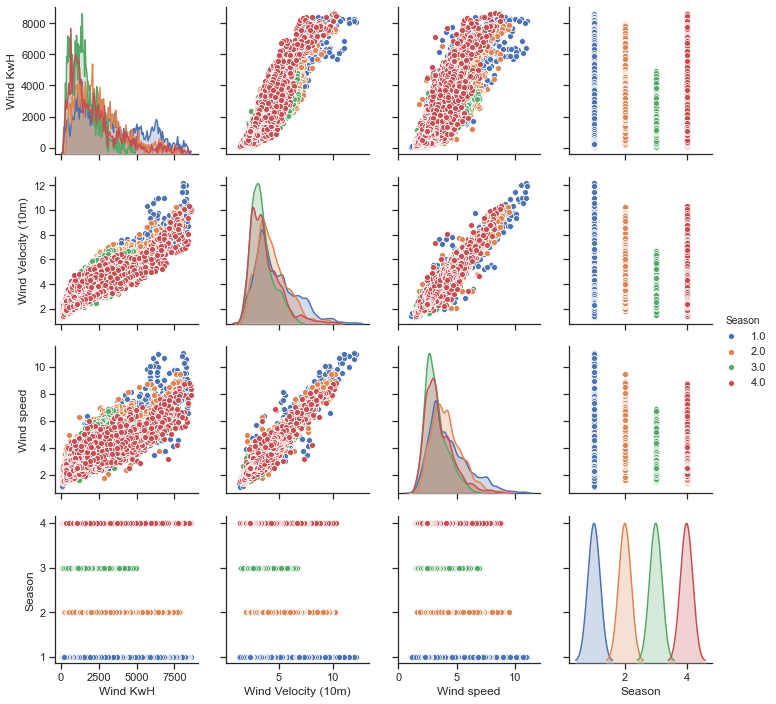

In [38]:
cols = ['Wind KwH', 'Wind Velocity (10m)', 'Wind speed', 'Season']

scatter_df = France[cols]

sns.set(style="ticks")

df = scatter_df
sns.pairplot(df, hue = "Season", diag_kws={'bw': 0.2})
plt.show()

In [37]:
plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()

data = {'Month': France['Month'], 'Avg_Temp': France['Temperature'], 'Solar KwH': France['Solar KwH']}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Average Solar Generation by Month', fontsize=16)
ax1.tick_params(axis='y')

ax2 = sns.barplot(x='Month', y='Solar KwH', data = df, color = 'gold')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='Month', y='Avg_Temp', data = df, sort=False, color= 'blue')

ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Solar KwH', fontsize=16)

ax2.tick_params(axis='y')
ax2.set_ylabel('Temperature (Kelvin)', fontsize=16)
plt.show()

In [41]:
Renewable = pd.read_csv('/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Generation/France_Renewable_Processed.csv')

## 4. Linear Regression

In [42]:
Daily = France.groupby(np.arange(len(df))//24).mean()
del Daily['Hour']
Daily.head()

Solar KwH     Wind KwH        Total  Temperature  Relative Humidity  \
0  317.041667  3373.250000  3690.291667   279.748750          89.072500   
1  232.708333  5929.958333  6162.666667   280.177083          87.923750   
2  164.875000  5301.541667  5466.416667   278.888333          88.360417   
3  228.666667  4944.125000  5172.791667   279.704583          88.643333   
4  258.833333  4664.083333  4922.916667   279.049583          88.458333   

     Pressure  Wind speed  Wind direction  Rainfall  Snowfall  Snow depth  \
0  990.578750    4.162500      135.366250  0.078333  0.000000         0.0   
1  982.401667    5.735833      215.495000  0.361667  0.004167         0.0   
2  974.738750    5.467083      201.557917  0.466667  0.008333         0.0   
3  965.952083    5.476667      234.968333  0.167500  0.004167         0.0   
4  966.834583    5.390000      231.648750  0.130000  0.000833         0.0   

   Wind Velocity (10m)  Atmospheric Horizontal Radiation  \
0             4.730417                          3.616250   
1             6.605000                          4.626667   
2             6.260417                          0.747917   
3             5.955000                          5.530833   
4             5.848333                          4.575833   

   Atmospheric Ground Radiation  Month  Day  Season  
0                     31.305417    1.0  4.0     1.0  
1                     32.537917    1.0  5.0     1.0  
2                     21.055833    1.0  6.0     1.0  
3                     33.332083    1.0  0.0     1.0  
4                     33.455833    1.0  1.0     1.0

In [43]:
correlations = Daily.corr(method='pearson')
correlations_price = abs(correlations['Wind KwH'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Wind KwH                            1.000000
Total                               0.967306
Wind Velocity (10m)                 0.948728
Wind speed                          0.896613
Solar KwH                           0.471084
Atmospheric Horizontal Radiation    0.424155
Temperature                         0.386652
Relative Humidity                   0.379000
Rainfall                            0.330484
Month                               0.320119
Season                              0.320111
Pressure                            0.300790
Snowfall                            0.248221
Atmospheric Ground Radiation        0.209191
Wind direction                      0.104531
Snow depth                          0.070756


In [56]:
print(len(Daily))

365


In [57]:
df = Daily[['Wind Velocity (10m)', 'Wind speed', 'Temperature', 'Relative Humidity', 'Rainfall', 'Month', 'Wind KwH']]

trainSet = df[0:234]
testSet = df[234:365]

XX_elect_train = trainSet.drop('Wind KwH', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Wind KwH', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Wind KwH']
YY_elect_test = testSet['Wind KwH']

trainSet.head()

Wind Velocity (10m)  Wind speed  Temperature  Relative Humidity  Rainfall  \
0             4.730417    4.162500   279.748750          89.072500  0.078333   
1             6.605000    5.735833   280.177083          87.923750  0.361667   
2             6.260417    5.467083   278.888333          88.360417  0.466667   
3             5.955000    5.476667   279.704583          88.643333  0.167500   
4             5.848333    5.390000   279.049583          88.458333  0.130000   

   Month     Wind KwH  
0    1.0  3373.250000  
1    1.0  5929.958333  
2    1.0  5301.541667  
3    1.0  4944.125000  
4    1.0  4664.083333

In [58]:
from sklearn.linear_model import LinearRegression

lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  -0.43530685990063334
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0  Wind Velocity (10m)              1961.337319
1           Wind speed              -947.264669
2          Temperature                27.848957
3    Relative Humidity               -16.760918
4             Rainfall               176.511467
5                Month              -202.312779

In [59]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='g')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

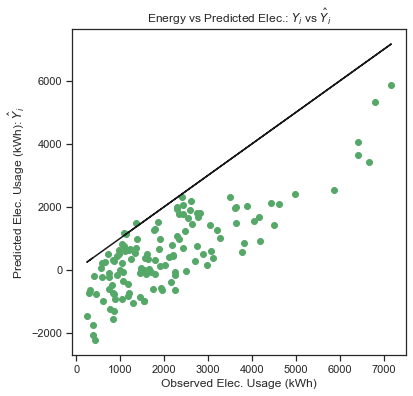

In [60]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='g')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

### Hourly

In [61]:
correlations = France.corr(method='pearson')
correlations_price = abs(correlations['Wind KwH'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Wind KwH                            1.000000
Wind Velocity (10m)                 0.880759
Wind speed                          0.809981
Total                               0.769697
Temperature                         0.315001
Season                              0.291368
Month                               0.291294
Pressure                            0.285646
Rainfall                            0.250157
Atmospheric Horizontal Radiation    0.199574
Snowfall                            0.190575
Relative Humidity                   0.180323
Solar KwH                           0.162528
Wind direction                      0.093105
Atmospheric Ground Radiation        0.062635
Snow depth                          0.061754


In [63]:
df = France[['Wind Velocity (10m)', 'Wind speed', 'Temperature', 'Season', 'Month', 'Pressure', 'Wind KwH']]

trainSet = df[0:6132]
testSet = df[6132:8760]

XX_elect_train = trainSet.drop('Wind KwH', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Wind KwH', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Wind KwH']
YY_elect_test = testSet['Wind KwH']

trainSet.head()

Wind Velocity (10m)  Wind speed  Temperature  Season  Month  Pressure  \
0                 2.86        5.70       279.84     1.0    1.0    982.65   
1                 2.68        2.13       282.79     1.0    1.0   1005.81   
2                 2.51        2.31       278.20     1.0    1.0    994.89   
3                 2.45        2.29       278.11     1.0    1.0    994.89   
4                 2.35        2.34       278.08     1.0    1.0    994.74   

   Wind KwH  
0    2082.0  
1    1690.0  
2    1414.0  
3    1200.0  
4    1000.0

In [64]:
lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  0.7586535641842391
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0  Wind Velocity (10m)              1387.708477
1           Wind speed              -462.265189
2          Temperature               -51.177697
3               Season              -112.735134
4                Month                55.381604
5             Pressure                 3.260885

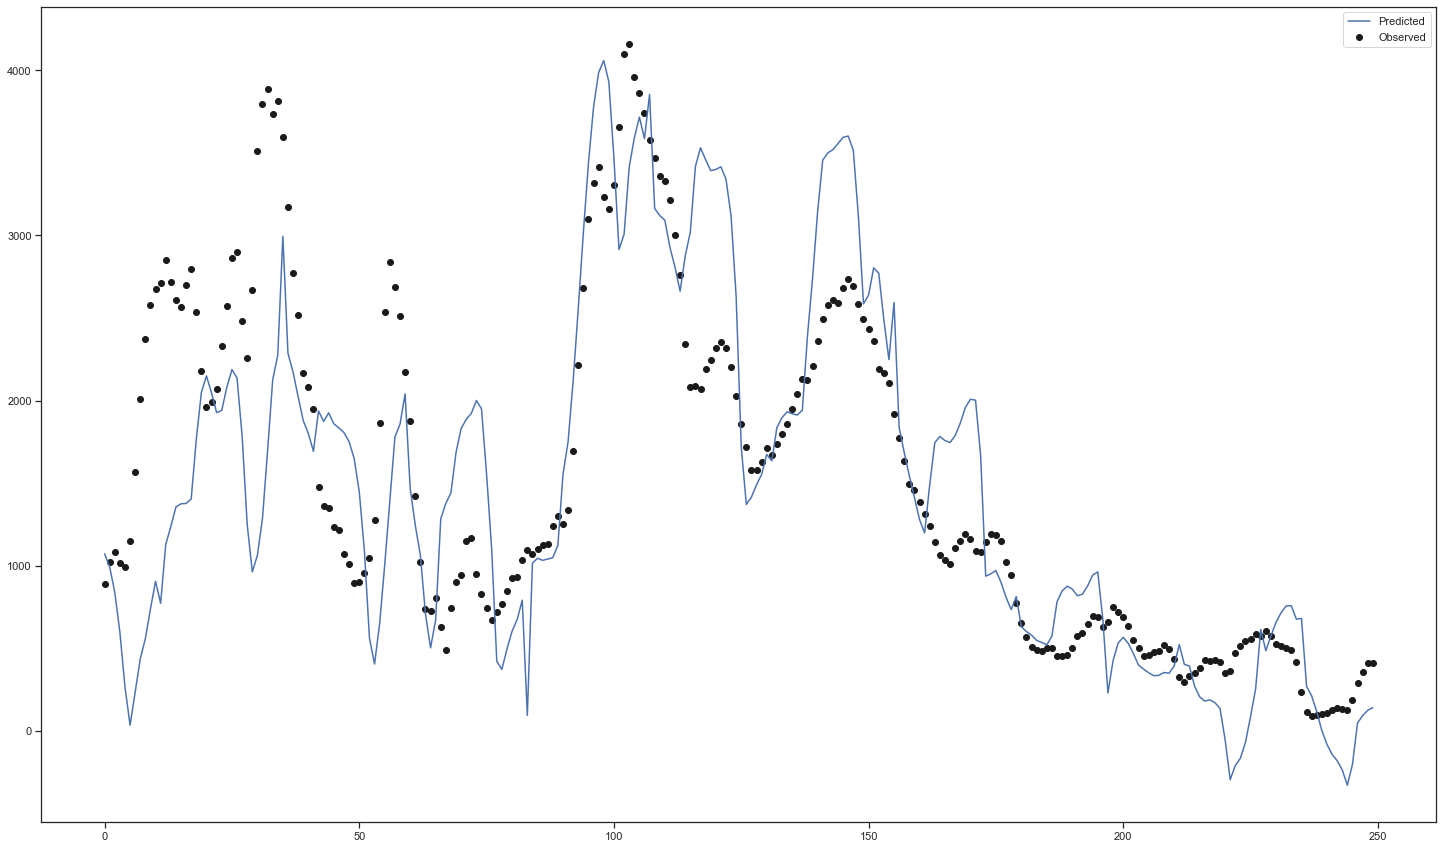

In [65]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='b')
plt.legend(loc='upper right')

In [66]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='b')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

## KNN

In [67]:
import sklearn
import sklearn.datasets
import sklearn.model_selection
import sklearn.decomposition
import sklearn.neighbors
import sklearn.metrics

In [69]:
normalized_electricity = France['Wind KwH'] - France['Wind KwH'].mean()

In [70]:
def accuracy_for_k(k, x, y):
    split_data = sklearn.model_selection.train_test_split(x,y,test_size = 0.33,random_state=99)
    X_train, X_test, Y_train, Y_test = split_data
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    knn.fit(X_train, Y_train)
    value = knn.score(X_test, Y_test)
    return value

In [71]:
df = France[['Wind Velocity (10m)', 'Wind speed', 'Temperature', 'Season', 'Month', 'Pressure', 'Wind KwH']]

trainSet = df[0:6132]
testSet = df[6132:8760]

XX_elect_train = trainSet.drop('Wind KwH', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Wind KwH', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Wind KwH']
YY_elect_test = testSet['Wind KwH']

trainSet.head()

Wind Velocity (10m)  Wind speed  Temperature  Season  Month  Pressure  \
0                 2.86        5.70       279.84     1.0    1.0    982.65   
1                 2.68        2.13       282.79     1.0    1.0   1005.81   
2                 2.51        2.31       278.20     1.0    1.0    994.89   
3                 2.45        2.29       278.11     1.0    1.0    994.89   
4                 2.35        2.34       278.08     1.0    1.0    994.74   

   Wind KwH  
0    2082.0  
1    1690.0  
2    1414.0  
3    1200.0  
4    1000.0

0.887443134620568
The optimal value of k is: 3


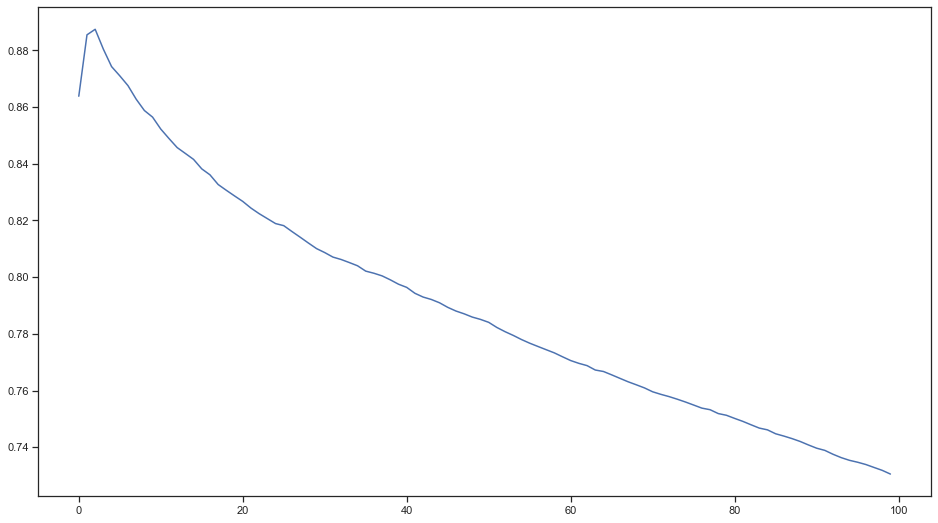

In [72]:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x= XX_elect_train,y = YY_elect_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print (scores.max())
print ('The optimal value of k is:',k_opt)

line1, = plt.plot(scores.T)

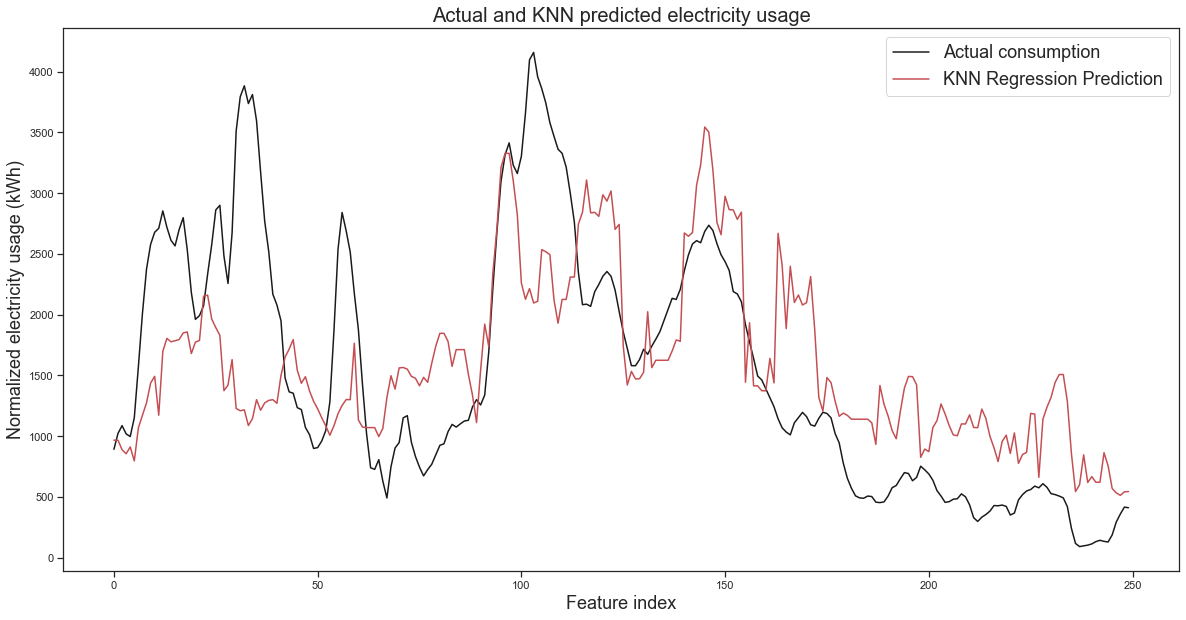

In [73]:
knn_reg = sklearn.neighbors.KNeighborsRegressor(n_neighbors=12,weights='uniform')
knn_reg.fit(XX_elect_train,YY_elect_train)
YY_elect_pred = knn_reg.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, = plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, = plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and KNN predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

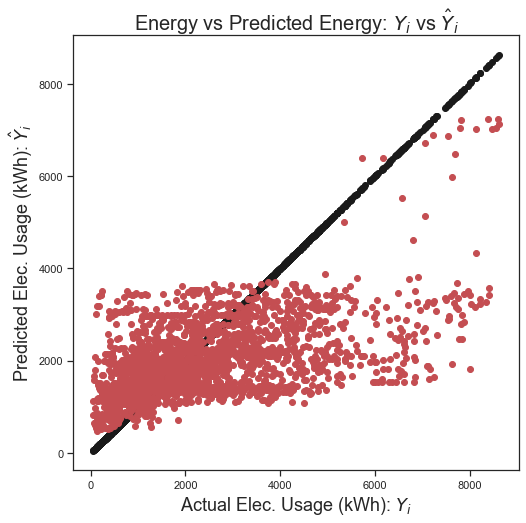

In [74]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)

plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

## Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import cross_val_score

estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in YY_elect_train]
np.random.seed(11111)

for i in estimators:
    
    model = rfr(n_estimators = i, max_depth = None)
    scores_rfr = cross_val_score(model, XX_elect_train, yt, cv = 10, scoring = 'explained_variance')
    
    print('estimators:', i)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean() + scores_rfr.std()*2) 
    std_rfrs_lower.append(scores_rfr.mean() - scores_rfr.std()*2)

estimators: 2
Est. explained variance: 0.59 (+/- 0.17)

estimators: 5
Est. explained variance: 0.68 (+/- 0.13)

estimators: 10
Est. explained variance: 0.70 (+/- 0.15)

estimators: 15
Est. explained variance: 0.71 (+/- 0.13)

estimators: 20
Est. explained variance: 0.71 (+/- 0.16)

estimators: 25
Est. explained variance: 0.71 (+/- 0.15)

estimators: 30
Est. explained variance: 0.71 (+/- 0.15)

estimators: 35
Est. explained variance: 0.72 (+/- 0.14)

estimators: 40
Est. explained variance: 0.72 (+/- 0.15)

estimators: 45
Est. explained variance: 0.72 (+/- 0.15)

estimators: 50
Est. explained variance: 0.72 (+/- 0.14)

estimators: 55
Est. explained variance: 0.72 (+/- 0.14)

estimators: 60
Est. explained variance: 0.72 (+/- 0.14)

estimators: 65
Est. explained variance: 0.72 (+/- 0.14)

estimators: 70
Est. explained variance: 0.72 (+/- 0.15)

estimators: 75
Est. explained variance: 0.73 (+/- 0.14)

estimators: 80
Est. explained variance: 0.72 (+/- 0.14)



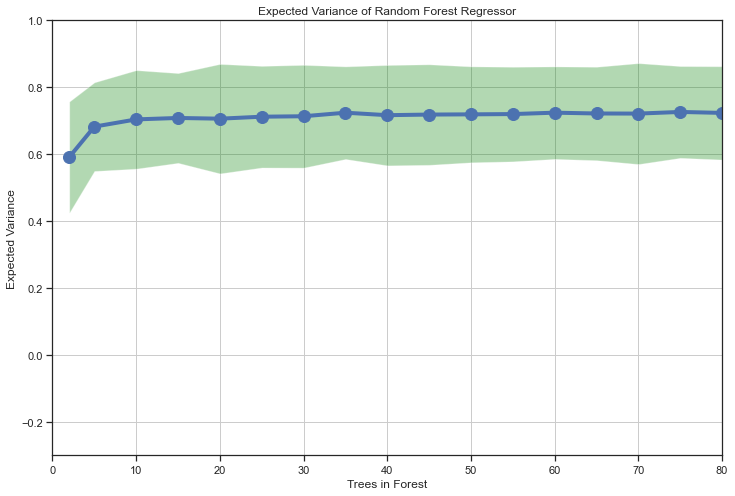

In [77]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)

ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)

ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

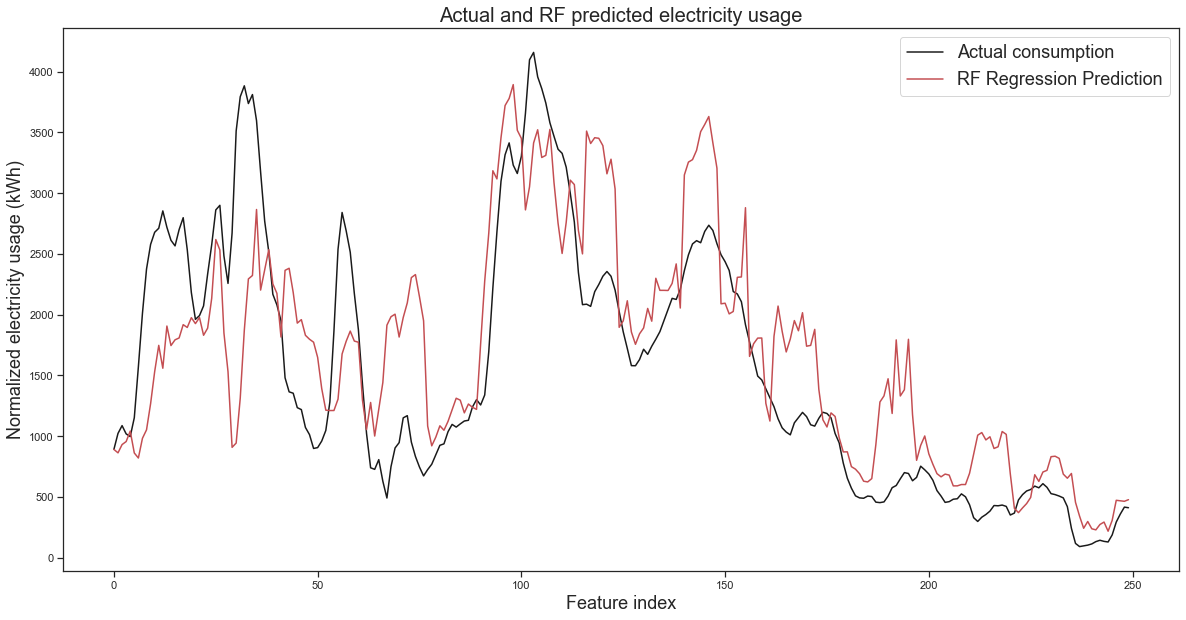

In [78]:
from sklearn.ensemble import RandomForestRegressor

RF_e = RandomForestRegressor(n_estimators = 20, max_depth=None, min_samples_split = 4, random_state=0)
RF_e.fit(XX_elect_train, YY_elect_train)
YY_elect_pred=RF_e.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and RF predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [79]:
print (RF_e.score(XX_elect_test,YY_elect_test))

0.7014611298336451


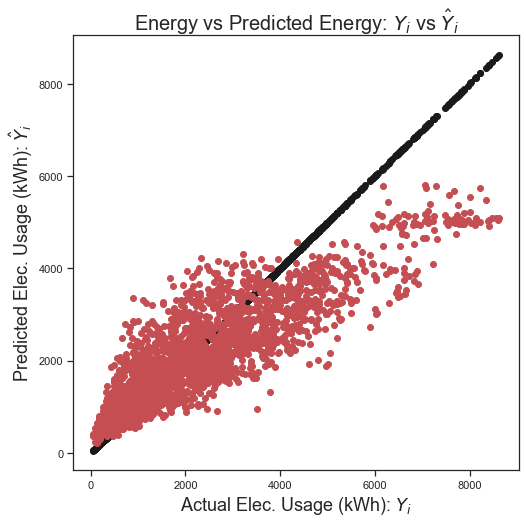

In [80]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)
plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

In [168]:
correlations = France.corr(method='pearson')
correlations_price = abs(correlations['Solar KwH'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Solar KwH                           1.000000
Atmospheric Horizontal Radiation    0.896812
Relative Humidity                   0.771132
Atmospheric Ground Radiation        0.759181
Total                               0.504824
Temperature                         0.493131
Wind KwH                            0.162528
Wind speed                          0.148919
Wind Velocity (10m)                 0.141872
Season                              0.121554
Rainfall                            0.079731
Snowfall                            0.078282
Pressure                            0.070114
Snow depth                          0.063716


In [174]:
lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  0.8231927269552488
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0  Atmospheric Horizontal Radiation                 5.575171
1                 Relative Humidity                -1.520848
2      Atmospheric Ground Radiation                 5.275530
3                       Temperature               -15.989410
4                            Season                21.133017
5                          Pressure                 4.662875

In [175]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='b')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

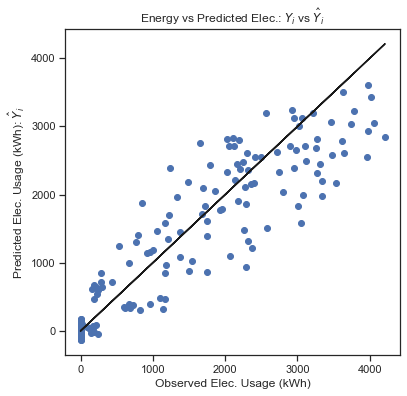

In [176]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='b')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

## KNN

In [ ]:
import sklearn
import sklearn.datasets
import sklearn.model_selection
import sklearn.decomposition
import sklearn.neighbors
import sklearn.metrics

In [ ]:
normalized_electricity = France['Solar KwH'] - France['Solar KwH'].mean()

In [ ]:
def accuracy_for_k(k, x, y):
    split_data = sklearn.model_selection.train_test_split(x,y,test_size = 0.33,random_state=99)
    X_train, X_test, Y_train, Y_test = split_data
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    knn.fit(X_train, Y_train)
    value = knn.score(X_test, Y_test)
    return value

In [177]:
df = France[['Atmospheric Horizontal Radiation', 'Relative Humidity', 'Atmospheric Ground Radiation', 'Temperature', 
             'Season', 'Pressure', 'Solar KwH']]

trainSet = df[0:6132]
testSet = df[6132:8760]

XX_elect_train = trainSet.drop('Solar KwH', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Solar KwH', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Solar KwH']
YY_elect_test = testSet['Solar KwH']

trainSet.head()

Atmospheric Horizontal Radiation  Relative Humidity  \
0                               0.0              92.48   
1                               0.0              83.61   
2                               0.0              96.71   
3                               0.0              96.42   
4                               0.0              95.59   

   Atmospheric Ground Radiation  Temperature  Season  Pressure  Solar KwH  
0                           0.0       279.84     1.0    982.65       -1.0  
1                           0.0       282.79     1.0   1005.81       -1.0  
2                           0.0       278.20     1.0    994.89       -1.0  
3                           0.0       278.11     1.0    994.89       -1.0  
4                           0.0       278.08     1.0    994.74       -1.0

0.94157160472394
The optimal value of k is: 6


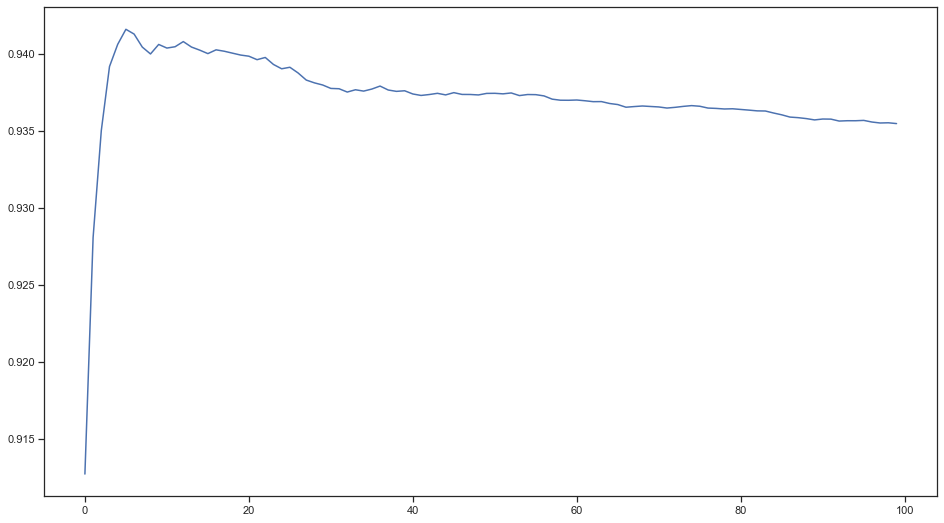

In [178]:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x= XX_elect_train,y = YY_elect_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print (scores.max())
print ('The optimal value of k is:',k_opt)

line1, = plt.plot(scores.T)

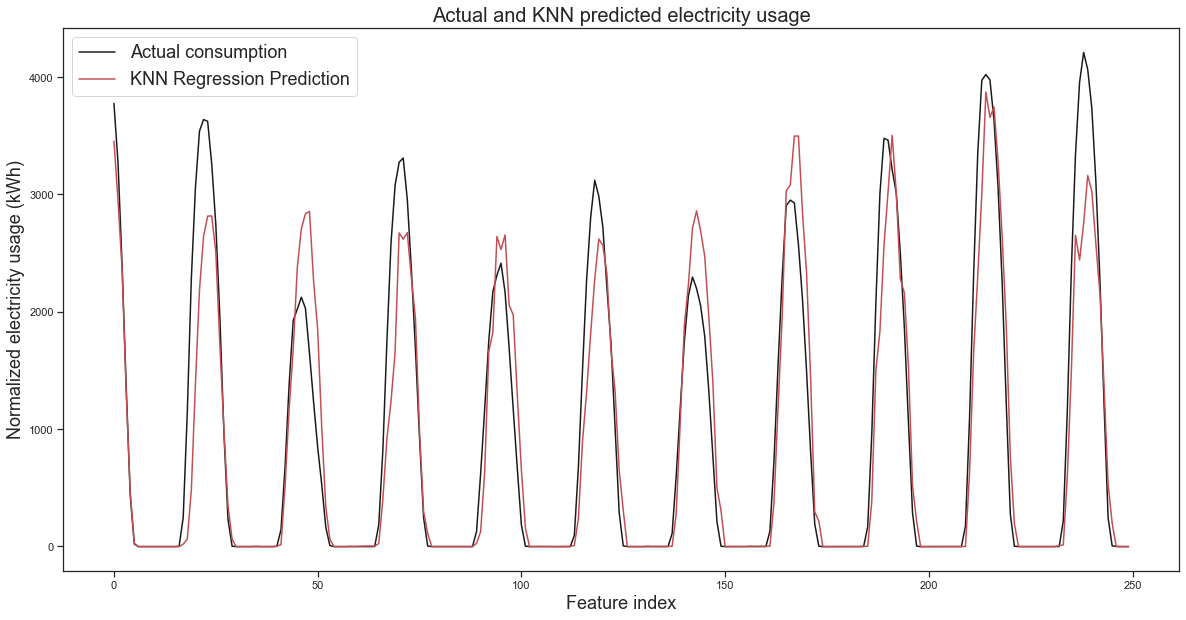

In [179]:
knn_reg = sklearn.neighbors.KNeighborsRegressor(n_neighbors=12,weights='uniform')
knn_reg.fit(XX_elect_train,YY_elect_train)
YY_elect_pred = knn_reg.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, = plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, = plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and KNN predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

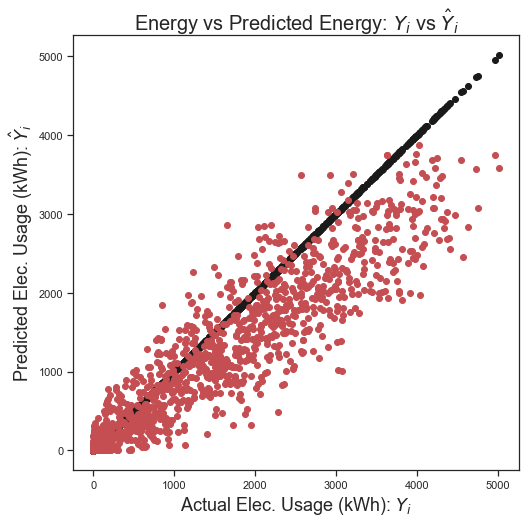

In [180]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)

plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

## Random Forest

In [181]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import cross_val_score

estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in YY_elect_train]
np.random.seed(11111)

for i in estimators:
    
    model = rfr(n_estimators = i, max_depth = None)
    scores_rfr = cross_val_score(model, XX_elect_train, yt, cv = 10, scoring = 'explained_variance')
    
    print('estimators:', i)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean() + scores_rfr.std()*2) 
    std_rfrs_lower.append(scores_rfr.mean() - scores_rfr.std()*2)

estimators: 2
Est. explained variance: 0.91 (+/- 0.05)

estimators: 5
Est. explained variance: 0.93 (+/- 0.04)

estimators: 10
Est. explained variance: 0.94 (+/- 0.04)

estimators: 15
Est. explained variance: 0.94 (+/- 0.04)

estimators: 20
Est. explained variance: 0.94 (+/- 0.04)

estimators: 25
Est. explained variance: 0.94 (+/- 0.04)

estimators: 30
Est. explained variance: 0.94 (+/- 0.03)

estimators: 35
Est. explained variance: 0.94 (+/- 0.04)

estimators: 40
Est. explained variance: 0.94 (+/- 0.04)

estimators: 45
Est. explained variance: 0.94 (+/- 0.03)

estimators: 50
Est. explained variance: 0.94 (+/- 0.04)

estimators: 55
Est. explained variance: 0.94 (+/- 0.04)

estimators: 60
Est. explained variance: 0.94 (+/- 0.03)

estimators: 65
Est. explained variance: 0.94 (+/- 0.04)

estimators: 70
Est. explained variance: 0.94 (+/- 0.03)

estimators: 75
Est. explained variance: 0.94 (+/- 0.03)

estimators: 80
Est. explained variance: 0.94 (+/- 0.04)



In [182]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)

ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)

ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

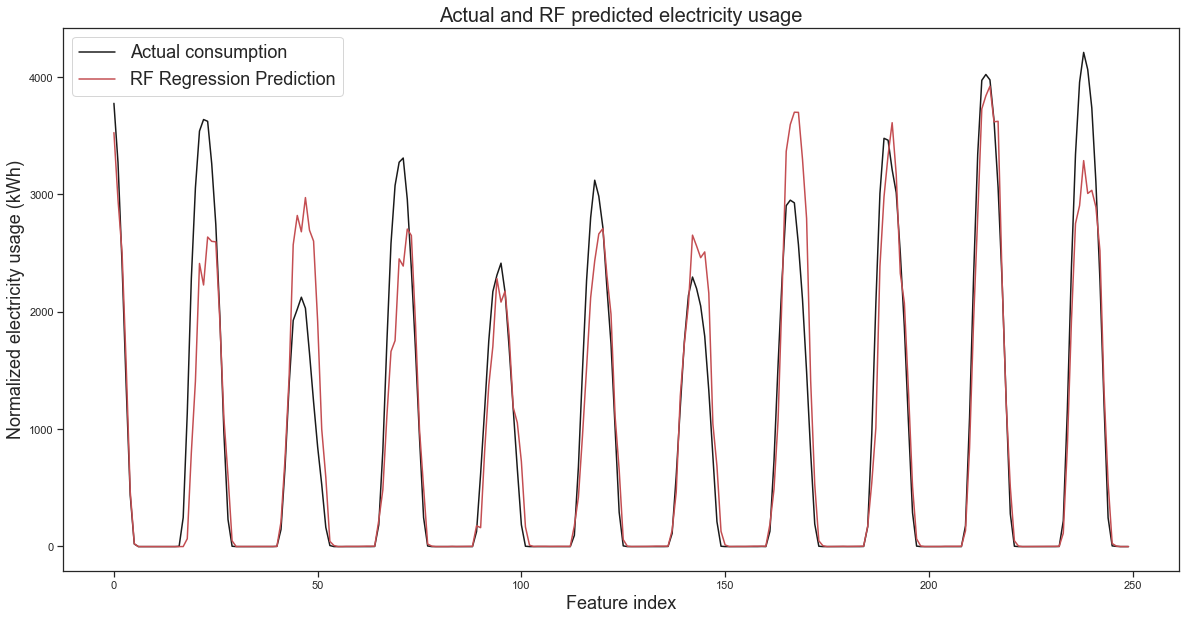

In [183]:
from sklearn.ensemble import RandomForestRegressor

RF_e = RandomForestRegressor(n_estimators = 20, max_depth=None, min_samples_split = 4, random_state=0)
RF_e.fit(XX_elect_train, YY_elect_train)
YY_elect_pred=RF_e.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and RF predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [184]:
print (RF_e.score(XX_elect_test,YY_elect_test))

0.90086589007551


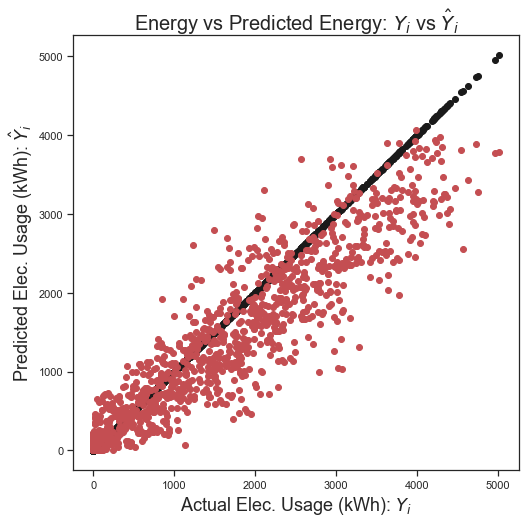

In [185]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)
plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

## 5. Feature Selection

In [81]:
Renewable.head()

Date  Solar KwH  Wind KwH   Total  Temperature  \
0  2016-01-01 00:00:00       -1.0    2082.0  2081.0       279.84   
1  2016-01-01 01:00:00       -1.0    1690.0  1689.0       282.79   
2  2016-01-01 02:00:00       -1.0    1414.0  1413.0       278.20   
3  2016-01-01 03:00:00       -1.0    1200.0  1199.0       278.11   
4  2016-01-01 04:00:00       -1.0    1000.0   999.0       278.08   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              92.48    982.65        5.70          155.61      0.45   
1              83.61   1005.81        2.13           89.96      0.01   
2              96.71    994.89        2.31          170.60      0.01   
3              96.42    994.89        2.29          171.33      0.01   
4              95.59    994.74        2.34          168.74      0.01   

   Snowfall  Snow depth  Wind Velocity (10m)  \
0       0.0         0.0                 2.86   
1       0.0         0.0                 2.68   
2       0.0         0.0                 2.51   
3       0.0         0.0                 2.45   
4       0.0         0.0                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0    1.0  4.0   
1                               0.0                           0.0    1.0  4.0   
2                               0.0                           0.0    1.0  4.0   
3                               0.0                           0.0    1.0  4.0   
4                               0.0                           0.0    1.0  4.0   

   Hour  Season  
0   0.0     1.0  
1   1.0     1.0  
2   2.0     1.0  
3   3.0     1.0  
4   4.0     1.0

In [82]:
correlations = Renewable.corr(method='pearson')
correlations_price = abs(correlations['Solar KwH'])
print(correlations_price[correlations_price > 0.10]
      .sort_values(ascending=False).to_string())

Solar KwH                           1.000000
Atmospheric Horizontal Radiation    0.896812
Relative Humidity                   0.771132
Atmospheric Ground Radiation        0.759181
Total                               0.504824
Temperature                         0.493131
Wind KwH                            0.162528
Wind speed                          0.148919
Wind Velocity (10m)                 0.141872
Season                              0.121554


In [83]:
correlations = Renewable.corr(method='pearson')
correlations_price = abs(correlations['Wind KwH'])
print(correlations_price[correlations_price > 0.10]
      .sort_values(ascending=False).to_string())

Wind KwH                            1.000000
Wind Velocity (10m)                 0.880759
Wind speed                          0.809981
Total                               0.769697
Temperature                         0.315001
Season                              0.291368
Month                               0.291294
Pressure                            0.285646
Rainfall                            0.250157
Atmospheric Horizontal Radiation    0.199574
Snowfall                            0.190575
Relative Humidity                   0.180323
Solar KwH                           0.162528


In [84]:
features = ['Atmospheric Horizontal Radiation', 'Relative Humidity', 'Atmospheric Ground Radiation', 'Temperature',
            'Season', 'Month']

In [85]:
Renewable.isnull().any()

Date                                False
Solar KwH                           False
Wind KwH                            False
Total                               False
Temperature                         False
Relative Humidity                   False
Pressure                            False
Wind speed                          False
Wind direction                      False
Rainfall                            False
Snowfall                            False
Snow depth                          False
Wind Velocity (10m)                 False
Atmospheric Horizontal Radiation    False
Atmospheric Ground Radiation        False
Month                               False
Day                                 False
Hour                                False
Season                              False
dtype: bool

In [86]:
def plot_model_rmse_and_loss(history):
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [87]:
def plot_learning_rate_schedule(history_lr, max_loss):
    plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
    plt.axis([1e-4, 1, 0, max_loss])
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.show()

In [88]:
def naive(Data):
    
    y = Renewable['Solar KwH'].values

    y_train = y[:6132]
    y_cv = y[6132 : 7446]
    y_test = y[7446:]
    
    naive_hour_ahead = y[7446 - 1 : 8760 - 1]
    rmse_naive = sqrt(mean_squared_error(y_test, naive_hour_ahead))

    print('RMSE of hour-ahead electricity price naive forecast: {}'.format(round(rmse_naive, 3)))

naive(Renewable)

RMSE of hour-ahead electricity price naive forecast: 345.576


In [89]:
def Nueral_Network (dataset, target, start, end, timesteps):
    
    data = []
    labels = []

    if end is None:
        end = len(dataset)
        
    for i in range(start, end):
        
        indices = range(i - timesteps, i)
        data.append(dataset[indices])
        labels.append(target[i])

    return np.array(data), np.array(labels)

In [90]:
train_set = 6132
validation_set = 7446
test_set = 8760

In [91]:
dataset = Renewable[features]

In [92]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

timesteps = 3
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaler_all.fit(dataset[:train_set])
scaled_dataset = scaler_all.transform(dataset)

Renewable = Renewable['Solar KwH'].values
scaler = MinMaxScaler(feature_range=(0, 1))

Renewable_reshaped = Renewable.reshape(-1, 1)
scaler.fit(Renewable_reshaped[:train_set])

scaled_variable = scaler.transform(Renewable_reshaped)
scaled_dataset = np.concatenate((scaled_dataset, scaled_variable), axis=1)

X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [93]:
X_train, y_train = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], 0, train_set, timesteps)
X_val, y_val = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], train_set, validation_set, timesteps)
X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [94]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

y_test_reshaped = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test_reshaped)

batch_size = 128
shuffle_size = 128

val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

In [95]:
tf.keras.backend.clear_session()
from keras import regularizers

mlp_lr = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, kernel_regularizer=regularizers.l2(0.0009), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 1e-4, amsgrad=True)
mlp_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)

Using TensorFlow backend.


In [96]:
Learning_Rate = mlp_lr.fit(train, epochs = 50, validation_data = val, callbacks=[lr_schedule])

Epoch 1/50
48/48 [==============================] - 0s 5ms/step - loss: 0.0587 - root_mean_squared_error: 0.2152 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2011
Epoch 2/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0331 - root_mean_squared_error: 0.1449 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1578
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.0215 - root_mean_squared_error: 0.0991 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1323
Epoch 4/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0201 - root_mean_squared_error: 0.0948 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1156
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0158 - root_mean_squared_error: 0.0723 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1267
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0144 - root_mean_squared_error: 0.0675 - val_loss: 0.0231 - val_root_mean_sq

48/48 [==============================] - 0s 3ms/step - loss: 712.2474 - root_mean_squared_error: 25.1540 - val_loss: 712.5093 - val_root_mean_squared_error: 25.1591
Epoch 49/50
48/48 [==============================] - 0s 3ms/step - loss: 710.8030 - root_mean_squared_error: 25.1239 - val_loss: 710.8683 - val_root_mean_squared_error: 25.1254
Epoch 50/50
48/48 [==============================] - 0s 3ms/step - loss: 709.0560 - root_mean_squared_error: 25.0860 - val_loss: 708.8552 - val_root_mean_squared_error: 25.0830


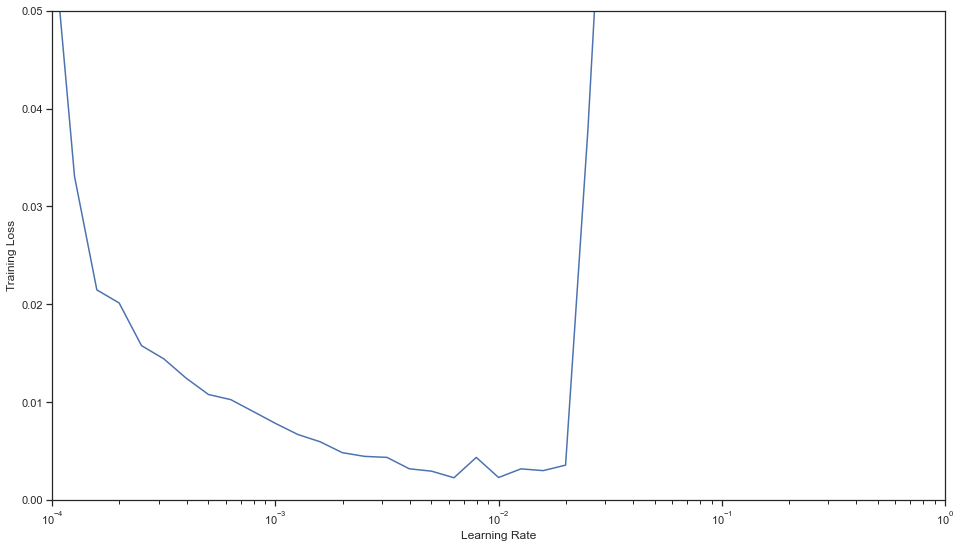

In [97]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [98]:
tf.keras.backend.clear_session()

MLP =  tf.keras.models.Sequential([
    TimeDistributed(Dense(150, kernel_regularizer=regularizers.l2(0.001), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu')),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  
])

optimizer = tf.keras.optimizers.Adam(lr = 0.001, amsgrad= True)
MLP.compile(loss = loss, optimizer = optimizer, metrics = metric)
MLP_Model = MLP.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
48/48 [==============================] - 0s 4ms/step - loss: 0.1153 - root_mean_squared_error: 10.5376 - val_loss: 0.1071 - val_root_mean_squared_error: 0.1835
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0641 - root_mean_squared_error: 0.0728 - val_loss: 0.0622 - val_root_mean_squared_error: 0.1256
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0424 - root_mean_squared_error: 0.0628 - val_loss: 0.0466 - val_root_mean_squared_error: 0.1222
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0302 - root_mean_squared_error: 0.0552 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1067
Epoch 5/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.0548 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1104
Epoch 6/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0193 - root_mean_squared_error: 0.0560 - val_loss: 0.0209 - val_root_

Epoch 49/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0455 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0376
Epoch 50/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0417 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0437
Epoch 51/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0424 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0388
Epoch 52/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0405 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0475
Epoch 53/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0412 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0316
Epoch 54/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0409 - val_loss: 0.0029 - val_

48/48 [==============================] - 0s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0393 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0364
Epoch 97/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0400 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0353
Epoch 98/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0393 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0276
Epoch 99/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0399 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0342
Epoch 100/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0404 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0367


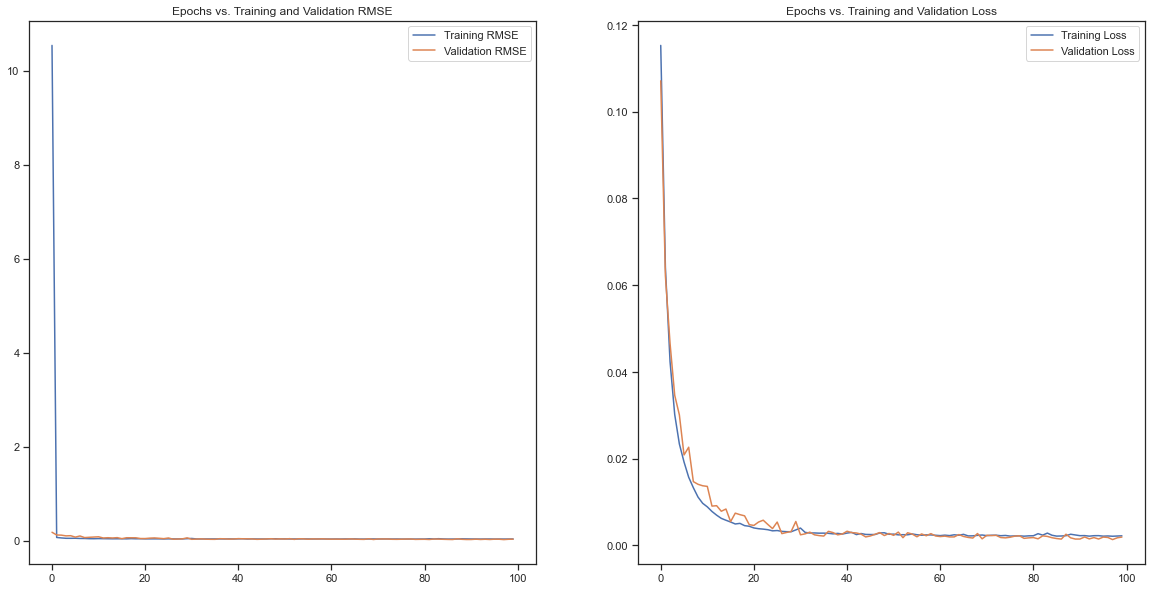

In [99]:
plot_model_rmse_and_loss(MLP_Model)

In [100]:
forecast = MLP.predict(X_test)
MLP_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, MLP_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 1163.563


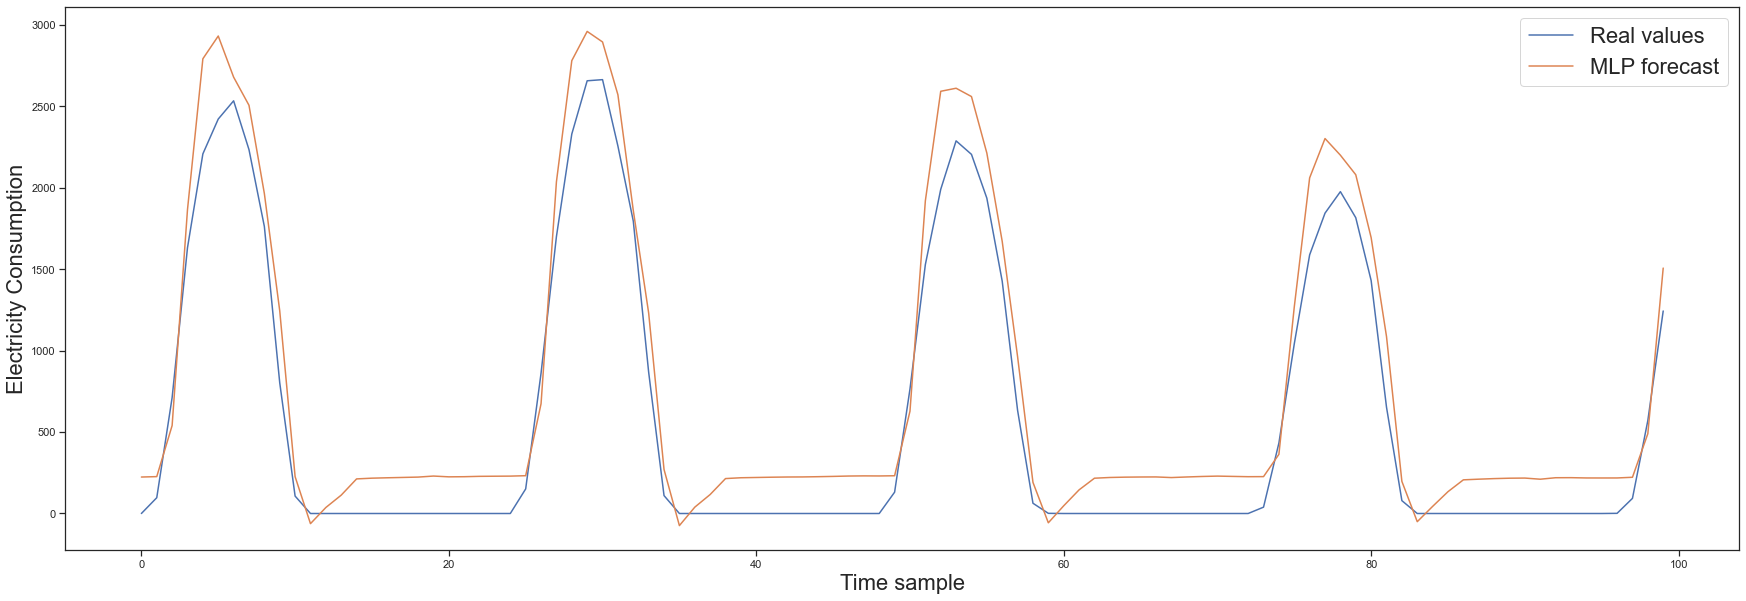

In [101]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(MLP_forecast[:100], label='MLP forecast')
ax.legend(prop={'size':22})
plt.show()

In [102]:
tf.keras.backend.clear_session()

lstm_learning = tf.keras.models.Sequential([
    LSTM(50, input_shape = input_shape, return_sequences=True),
    Flatten(),
    Dense(100, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
lstm_learning.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [103]:
Learning_Rate = lstm_learning.fit(train, epochs = 50, validation_data = val, callbacks = [lr_schedule])

Epoch 1/50
48/48 [==============================] - 1s 11ms/step - loss: 0.1790 - root_mean_squared_error: 0.2471 - val_loss: 0.1597 - val_root_mean_squared_error: 0.2386
Epoch 2/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1424 - root_mean_squared_error: 0.2060 - val_loss: 0.1422 - val_root_mean_squared_error: 0.2125
Epoch 3/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1256 - root_mean_squared_error: 0.1791 - val_loss: 0.1292 - val_root_mean_squared_error: 0.1981
Epoch 4/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1117 - root_mean_squared_error: 0.1612 - val_loss: 0.1276 - val_root_mean_squared_error: 0.2146
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0980 - root_mean_squared_error: 0.1454 - val_loss: 0.1244 - val_root_mean_squared_error: 0.2282
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0828 - root_mean_squared_error: 0.1241 - val_loss: 0.1175 - val_root_mean_s

48/48 [==============================] - 0s 5ms/step - loss: 360931.9375 - root_mean_squared_error: 598.9966 - val_loss: 34202.2461 - val_root_mean_squared_error: 178.1779
Epoch 49/50
48/48 [==============================] - 0s 4ms/step - loss: 1801228.8750 - root_mean_squared_error: 1340.8926 - val_loss: 91692.6797 - val_root_mean_squared_error: 295.6371
Epoch 50/50
48/48 [==============================] - 0s 4ms/step - loss: 3010860.0000 - root_mean_squared_error: 1733.5010 - val_loss: 205919.8125 - val_root_mean_squared_error: 445.4921


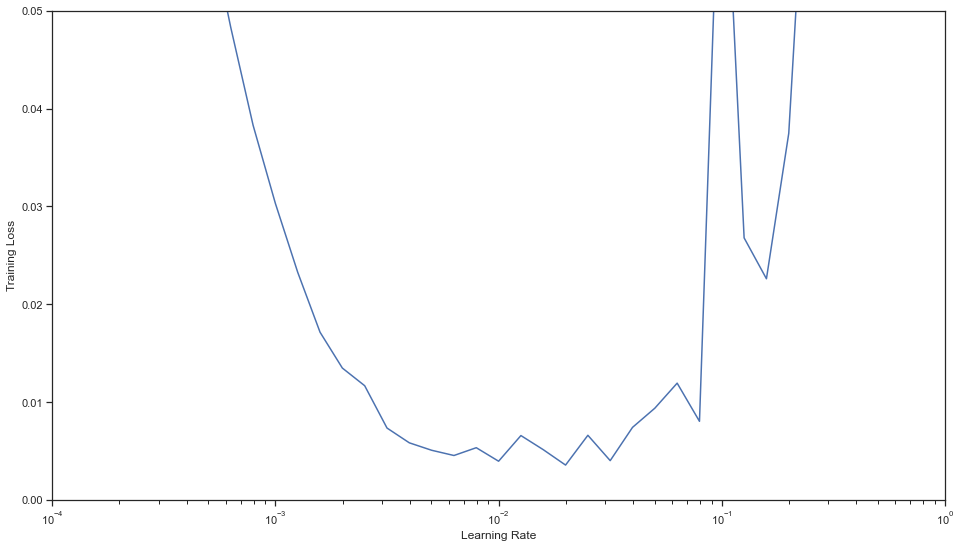

In [104]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [105]:
tf.keras.backend.clear_session()

LSTM = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, return_sequences = True),
    Flatten(),
    Dense(150, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = .001, amsgrad=True)
LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
LSTM_Model = LSTM.fit(train, epochs = 75, validation_data = val) 

Epoch 1/75
48/48 [==============================] - 1s 15ms/step - loss: 0.1310 - root_mean_squared_error: 187.1441 - val_loss: 0.0998 - val_root_mean_squared_error: 0.1884
Epoch 2/75
48/48 [==============================] - 0s 7ms/step - loss: 0.0632 - root_mean_squared_error: 0.1318 - val_loss: 0.0655 - val_root_mean_squared_error: 0.1816
Epoch 3/75
48/48 [==============================] - 0s 7ms/step - loss: 0.0338 - root_mean_squared_error: 0.0911 - val_loss: 0.0527 - val_root_mean_squared_error: 0.1807
Epoch 4/75
48/48 [==============================] - 0s 7ms/step - loss: 0.0207 - root_mean_squared_error: 0.0638 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1392
Epoch 5/75
48/48 [==============================] - 0s 7ms/step - loss: 0.0148 - root_mean_squared_error: 0.0561 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1389
Epoch 6/75
48/48 [==============================] - 0s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.0537 - val_loss: 0.0220 - val_root_mean

Epoch 49/75
48/48 [==============================] - 0s 7ms/step - loss: 0.0017 - root_mean_squared_error: 0.0357 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0613
Epoch 50/75
48/48 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0364 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0671
Epoch 51/75
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0335 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0730
Epoch 52/75
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0333 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0604
Epoch 53/75
48/48 [==============================] - 0s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0342 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0589
Epoch 54/75
48/48 [==============================] - 0s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0345 - val_loss: 0.0049 - val_root_m

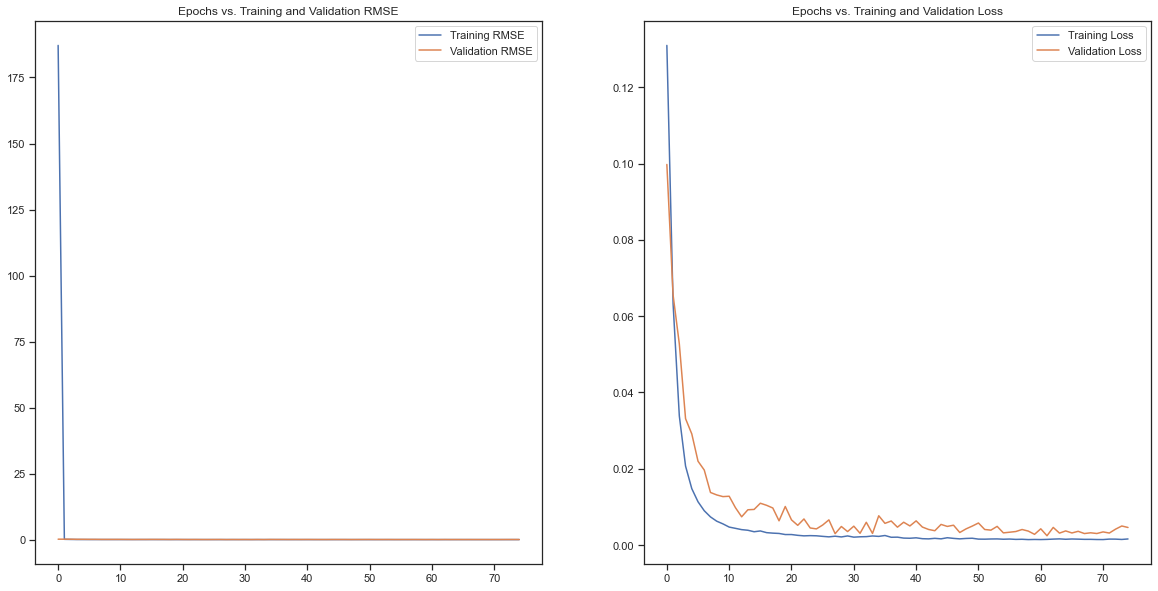

In [106]:
plot_model_rmse_and_loss(LSTM_Model)

In [107]:
forecast = LSTM.predict(X_test)
LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate LSTM forecast: 1255.567


In [108]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(LSTM_forecast[:100], label='LSTM forecast')
ax.legend(prop={'size':22})
plt.show()

In [109]:
tf.keras.backend.clear_session()

cnn_lr = tf.keras.models.Sequential([ Conv1D(filters=50, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lr.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0507 - root_mean_squared_error: 0.2062 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1893
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0326 - root_mean_squared_error: 0.1804 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1722
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0214 - root_mean_squared_error: 0.1463 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1713
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1804
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1678
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0189 - val_root_mean_sq

Epoch 49/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1414 - root_mean_squared_error: 0.3761 - val_loss: 0.0781 - val_root_mean_squared_error: 0.2794
Epoch 50/50
48/48 [==============================] - 0s 2ms/step - loss: 0.9619 - root_mean_squared_error: 0.9808 - val_loss: 0.1545 - val_root_mean_squared_error: 0.3931


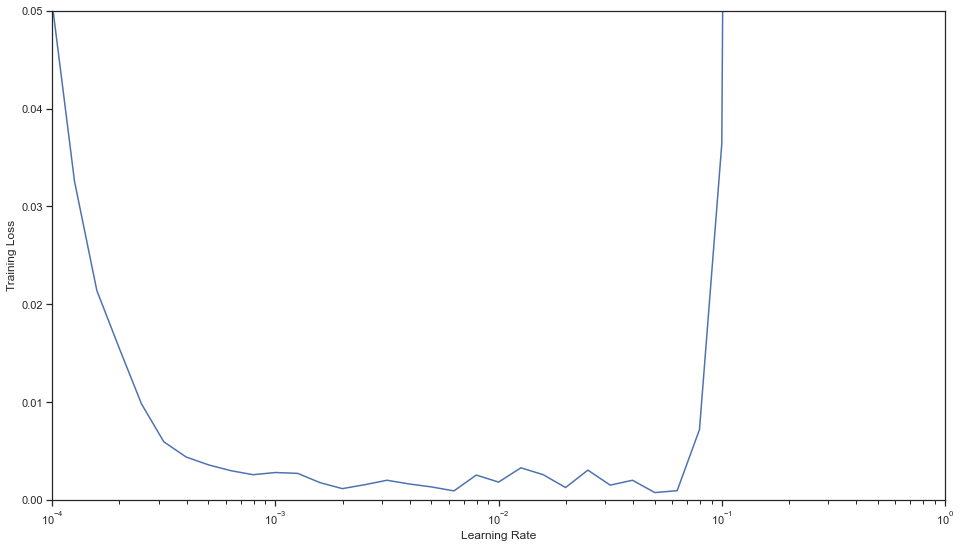

In [110]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [111]:
CNN = tf.keras.models.Sequential([Conv1D(filters = 75, kernel_size = 2, strides = 1, padding = 'causal',
                                         activation = 'relu', input_shape = input_shape),
                                  Flatten(),
                                  Dense(30, activation='relu'),
                                  Dense(1),
                                 ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_Model = CNN.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0485 - root_mean_squared_error: 0.2593 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2260
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1970
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1644
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1668
Epoch 6/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0286 - val_root_m

48/48 [==============================] - 0s 2ms/step - loss: 8.6960e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 49/100
48/48 [==============================] - 0s 2ms/step - loss: 8.5427e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784
Epoch 50/100
48/48 [==============================] - 0s 2ms/step - loss: 8.4182e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773
Epoch 51/100
48/48 [==============================] - 0s 2ms/step - loss: 8.3110e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 52/100
48/48 [==============================] - 0s 2ms/step - loss: 8.1620e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0762
Epoch 53/100
48/48 [==============================] - 0s 2ms/step - loss: 8.0431e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.

48/48 [==============================] - 0s 2ms/step - loss: 5.6147e-04 - root_mean_squared_error: 0.0237 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 95/100
48/48 [==============================] - 0s 2ms/step - loss: 5.5643e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 96/100
48/48 [==============================] - 0s 1ms/step - loss: 5.5100e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 97/100
48/48 [==============================] - 0s 2ms/step - loss: 5.4494e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 98/100
48/48 [==============================] - 0s 2ms/step - loss: 5.3840e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 99/100
48/48 [==============================] - 0s 2ms/step - loss: 5.3456e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.

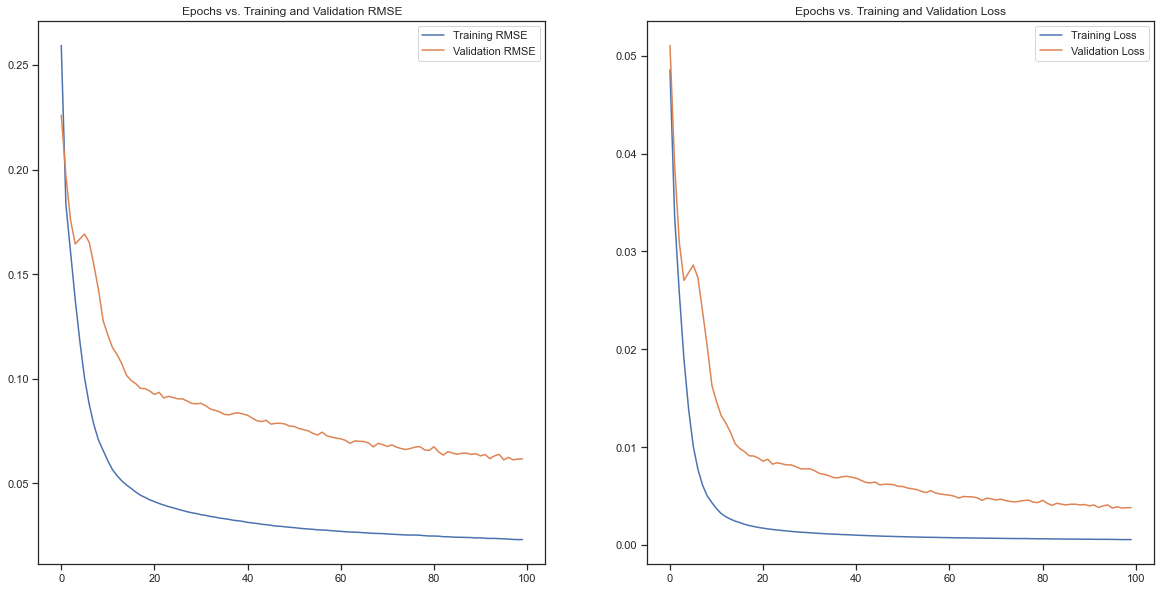

In [112]:
plot_model_rmse_and_loss(CNN_Model)

In [113]:
forecast =  CNN.predict(X_test)
CNN_forecast = scaler.inverse_transform(forecast)

rmse_CNN = sqrt(mean_squared_error(y_test, CNN_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}' .format(round(rmse_CNN, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 1098.252


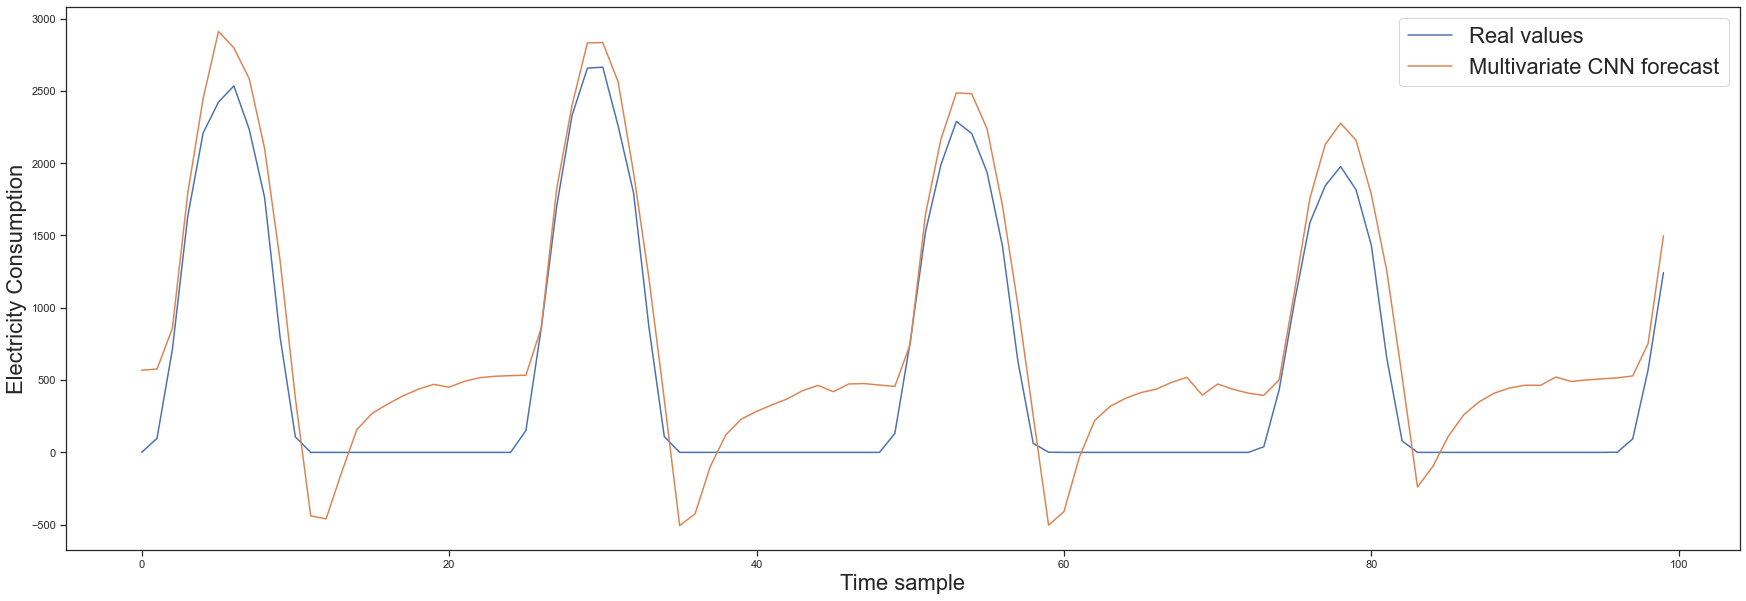

In [114]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(CNN_forecast[:100], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

In [117]:
tf.keras.backend.clear_session()

cnn_lstm = tf.keras.models.Sequential([ Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lstm.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0561 - root_mean_squared_error: 0.2164 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2281
Epoch 2/50
48/48 [==============================] - 0s 10ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1998
Epoch 3/50
48/48 [==============================] - 1s 11ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 4/50
48/48 [==============================] - 1s 11ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2031
Epoch 5/50
48/48 [==============================] - 1s 11ms/step - loss: 0.0088 - root_mean_squared_error: 0.0941 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2427
Epoch 6/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0333 - val_root_m

48/48 [==============================] - 0s 9ms/step - loss: 0.6329 - root_mean_squared_error: 0.7955 - val_loss: 0.0778 - val_root_mean_squared_error: 0.2789
Epoch 49/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1297 - root_mean_squared_error: 0.3601 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2588
Epoch 50/50
48/48 [==============================] - 0s 9ms/step - loss: 0.5571 - root_mean_squared_error: 0.7464 - val_loss: 0.4242 - val_root_mean_squared_error: 0.6513


In [118]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [119]:
CNN_LSTM = tf.keras.models.Sequential([Conv1D(filters=100, kernel_size=2,strides=1, padding='causal',
                                              activation='relu', input_shape = input_shape),
                                       LSTM(50, return_sequences=True),
                                       Flatten(),
                                       Dense(30, activation='relu'),
                                       Dense(1) 
                                      ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN_LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_LSTM_Model = CNN_LSTM.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0533 - root_mean_squared_error: 0.3446 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2403
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0351 - root_mean_squared_error: 0.1874 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2076
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1930
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0213 - root_mean_squared_error: 0.1460 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1920
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1950
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.0420 - val_root_

Epoch 49/100
48/48 [==============================] - 0s 5ms/step - loss: 9.8954e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 50/100
48/48 [==============================] - 0s 5ms/step - loss: 9.7051e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 51/100
48/48 [==============================] - 0s 5ms/step - loss: 9.5120e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 52/100
48/48 [==============================] - 0s 5ms/step - loss: 9.3330e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 53/100
48/48 [==============================] - 0s 5ms/step - loss: 9.1064e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0834
Epoch 54/100
48/48 [==============================] - 0s 6ms/step - loss: 8.9751e-04 - root_mean_squared_error: 0.0300 -

48/48 [==============================] - 0s 5ms/step - loss: 5.8943e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 96/100
48/48 [==============================] - 0s 5ms/step - loss: 5.8200e-04 - root_mean_squared_error: 0.0241 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0701
Epoch 97/100
48/48 [==============================] - 0s 5ms/step - loss: 5.8289e-04 - root_mean_squared_error: 0.0241 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 98/100
48/48 [==============================] - 0s 5ms/step - loss: 5.8203e-04 - root_mean_squared_error: 0.0241 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 99/100
48/48 [==============================] - 0s 5ms/step - loss: 5.6710e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 100/100
48/48 [==============================] - 0s 5ms/step - loss: 5.6649e-04 - root_mean_squared_error: 0.0238 - val_loss: 0

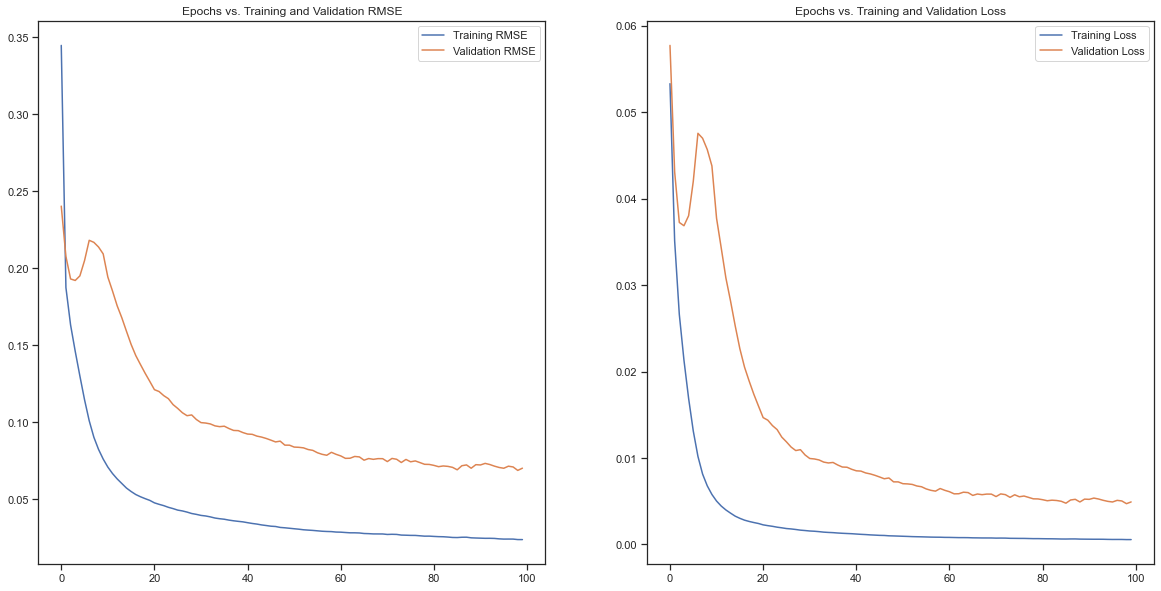

In [120]:
plot_model_rmse_and_loss(CNN_LSTM_Model)

In [121]:
forecast =  CNN_LSTM.predict(X_test)
CNN_LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, CNN_LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: 1442.099


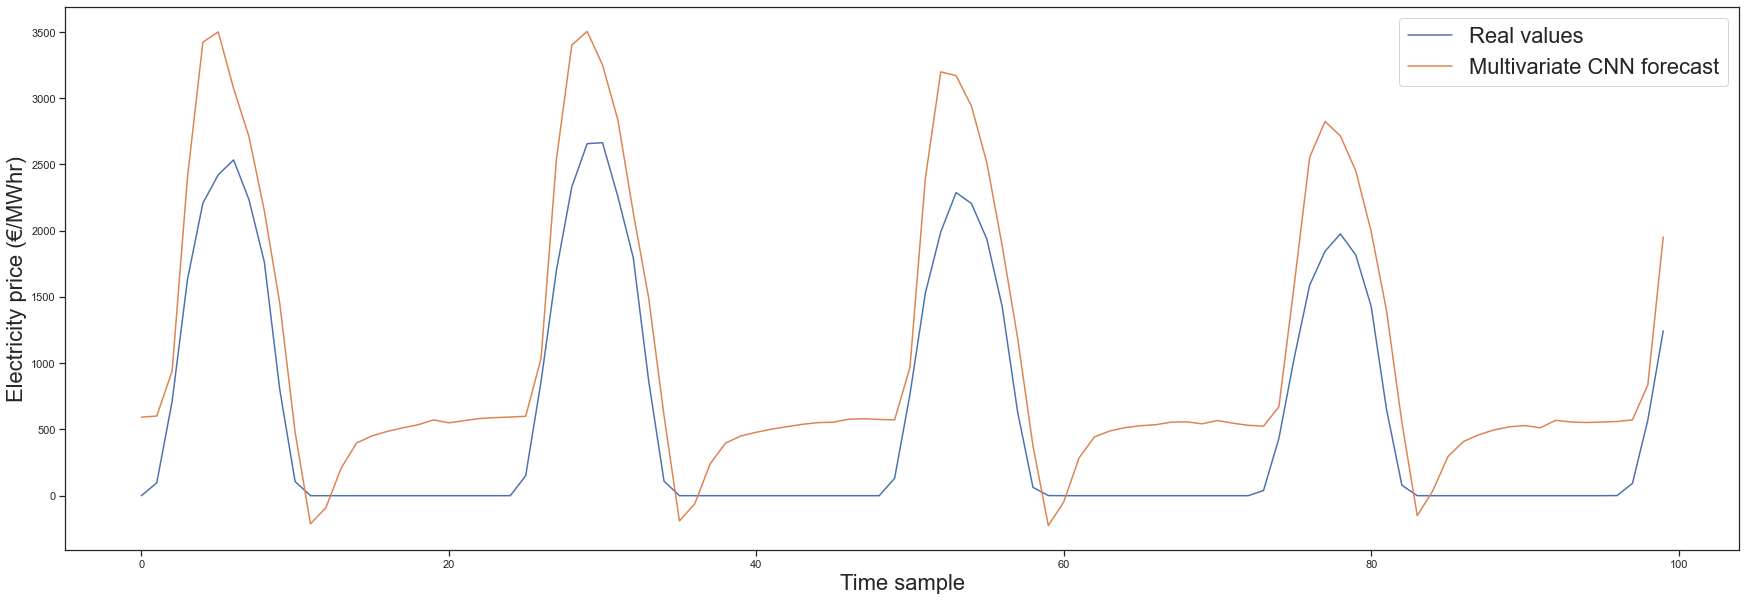

In [122]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity price (€/MWhr)', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(CNN_LSTM_forecast[:100], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

In [131]:
Renewable_wind = France.copy()

In [132]:
correlations = Renewable_wind.corr(method='pearson')
correlations_price = abs(correlations['Wind KwH'])
print(correlations_price[correlations_price > 0.10]
      .sort_values(ascending=False).to_string())

Wind KwH                            1.000000
Wind Velocity (10m)                 0.880759
Wind speed                          0.809981
Total                               0.769697
Temperature                         0.315001
Season                              0.291368
Month                               0.291294
Pressure                            0.285646
Rainfall                            0.250157
Atmospheric Horizontal Radiation    0.199574
Snowfall                            0.190575
Relative Humidity                   0.180323
Solar KwH                           0.162528


In [133]:
features = ['Wind speed', 'Wind direction', 'Pressure', 'Wind Velocity (10m)', 'Season', 'Month', 'Rainfall']

In [134]:
def naive(Data):
    
    y = Renewable_wind['Wind KwH'].values

    y_train = y[:6000]
    y_cv = y[6000 : 7200]
    y_test = y[7200:]
    
    naive_hour_ahead = y[7200 - 1 : 8760 - 1]
    rmse_naive = sqrt(mean_squared_error(y_test, naive_hour_ahead))

    print('RMSE of hour-ahead electricity price naive forecast: {}'.format(round(rmse_naive, 3)))

naive(Renewable)

RMSE of hour-ahead electricity price naive forecast: 214.897


In [135]:
train_set = 6000
validation_set = 7200
test_set = 8760

In [136]:
dataset = Renewable_wind[features]

In [137]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

timesteps = 3
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaler_all.fit(dataset[:train_set])
scaled_dataset = scaler_all.transform(dataset)

Renewable = Renewable_wind['Wind KwH'].values
scaler = MinMaxScaler(feature_range=(0, 1))

Renewable_reshaped = Renewable.reshape(-1, 1)
scaler.fit(Renewable_reshaped[:train_set])

scaled_variable = scaler.transform(Renewable_reshaped)
scaled_dataset = np.concatenate((scaled_dataset, scaled_variable), axis=1)

X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [138]:
X_train, y_train = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], 0, train_set, timesteps)
X_val, y_val = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], train_set, validation_set, timesteps)
X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [139]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

y_test_reshaped = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test_reshaped)

batch_size = 128
shuffle_size = 128

val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

In [140]:
tf.keras.backend.clear_session()
from keras import regularizers

mlp_lr = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, kernel_regularizer=regularizers.l2(0.0009), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 1e-4, amsgrad=True)
mlp_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)

In [141]:
Learning_Rate = mlp_lr.fit(train, epochs = 50, validation_data = val, callbacks=[lr_schedule])

Epoch 1/50
47/47 [==============================] - 0s 7ms/step - loss: 0.0835 - root_mean_squared_error: 0.2647 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1088
Epoch 2/50
47/47 [==============================] - 0s 3ms/step - loss: 0.0444 - root_mean_squared_error: 0.1770 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0987
Epoch 3/50
47/47 [==============================] - 0s 3ms/step - loss: 0.0237 - root_mean_squared_error: 0.1054 - val_loss: 0.0171 - val_root_mean_squared_error: 0.0690
Epoch 4/50
47/47 [==============================] - 0s 4ms/step - loss: 0.0175 - root_mean_squared_error: 0.0738 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0562
Epoch 5/50
47/47 [==============================] - 0s 4ms/step - loss: 0.0153 - root_mean_squared_error: 0.0624 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0439
Epoch 6/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0141 - root_mean_squared_error: 0.0587 - val_loss: 0.0120 - val_root_mean_sq

47/47 [==============================] - 0s 4ms/step - loss: 1281.2819 - root_mean_squared_error: 34.1740 - val_loss: 1285.3285 - val_root_mean_squared_error: 34.2598
Epoch 49/50
47/47 [==============================] - 0s 4ms/step - loss: 1277.6915 - root_mean_squared_error: 34.1696 - val_loss: 1281.8943 - val_root_mean_squared_error: 34.2547
Epoch 50/50
47/47 [==============================] - 0s 3ms/step - loss: 1274.4198 - root_mean_squared_error: 34.1639 - val_loss: 1278.5814 - val_root_mean_squared_error: 34.2485


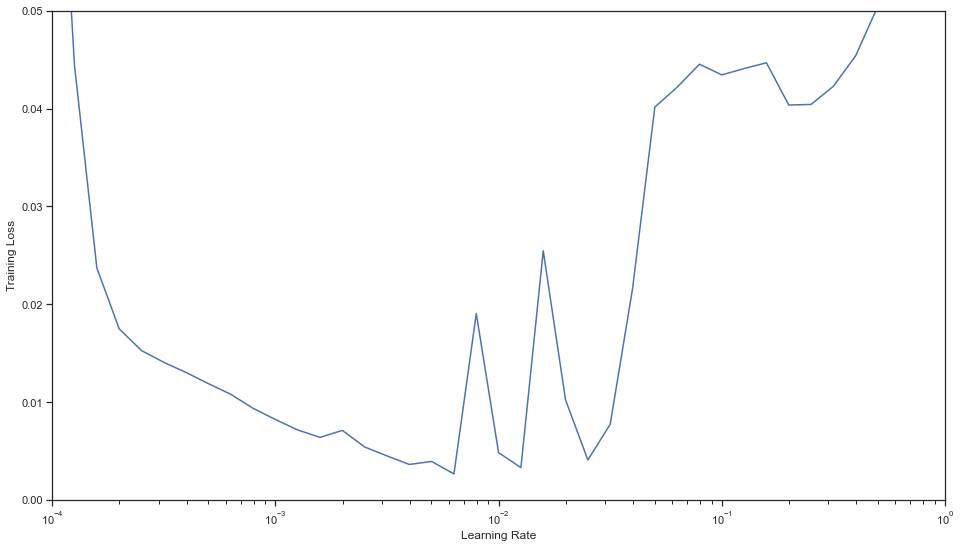

In [142]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [143]:
tf.keras.backend.clear_session()

MLP =  tf.keras.models.Sequential([
    TimeDistributed(Dense(150, kernel_regularizer=regularizers.l2(0.001), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu')),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  
])

optimizer = tf.keras.optimizers.Adam(lr = 0.001, amsgrad= True)
MLP.compile(loss = loss, optimizer = optimizer, metrics = metric)
MLP_Model = MLP.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
47/47 [==============================] - 0s 5ms/step - loss: 0.1445 - root_mean_squared_error: 13.9830 - val_loss: 0.0849 - val_root_mean_squared_error: 0.0620
Epoch 2/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0737 - root_mean_squared_error: 0.0867 - val_loss: 0.0560 - val_root_mean_squared_error: 0.0478
Epoch 3/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0509 - root_mean_squared_error: 0.0688 - val_loss: 0.0417 - val_root_mean_squared_error: 0.0450
Epoch 4/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0398 - root_mean_squared_error: 0.0657 - val_loss: 0.0341 - val_root_mean_squared_error: 0.0484
Epoch 5/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0329 - root_mean_squared_error: 0.0621 - val_loss: 0.0281 - val_root_mean_squared_error: 0.0410
Epoch 6/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0281 - root_mean_squared_error: 0.0597 - val_loss: 0.0242 - val_root_

47/47 [==============================] - 0s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0426 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0254
Epoch 49/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0433 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0285
Epoch 50/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0459 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0301
Epoch 51/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0482 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0381
Epoch 52/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0487 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0274
Epoch 53/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0429 - val_loss: 0.0019 - val_root_mean_squ

Epoch 96/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0379 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0249
Epoch 97/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0371 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0226
Epoch 98/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0386 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0222
Epoch 99/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0389 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0235
Epoch 100/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0378 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0223


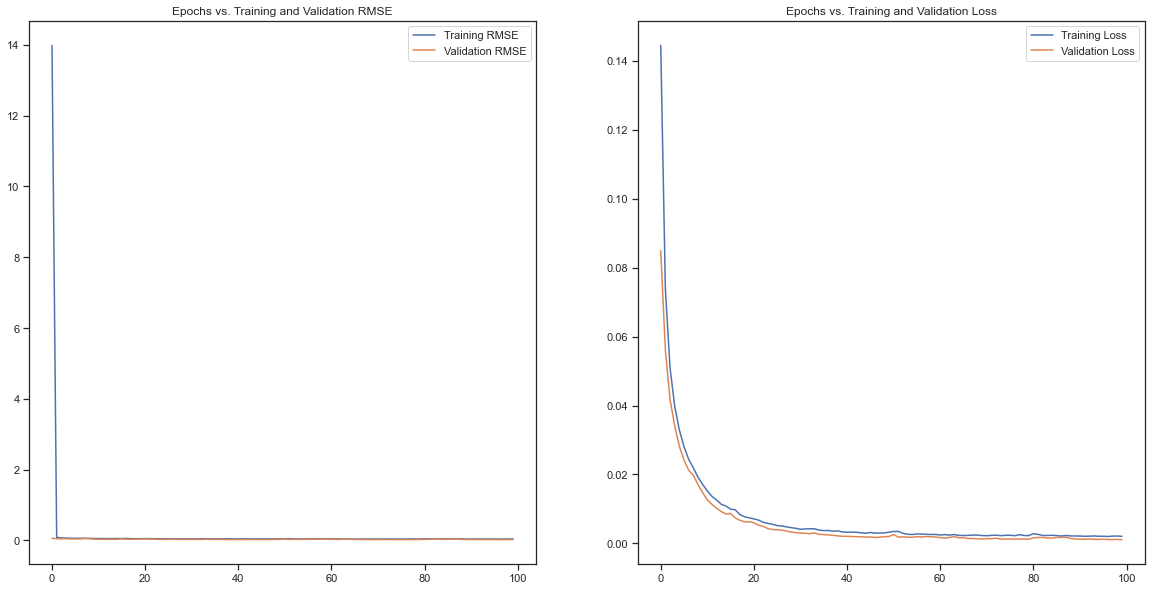

In [144]:
plot_model_rmse_and_loss(MLP_Model)

In [145]:
forecast = MLP.predict(X_test)
MLP_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, MLP_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 3066.294


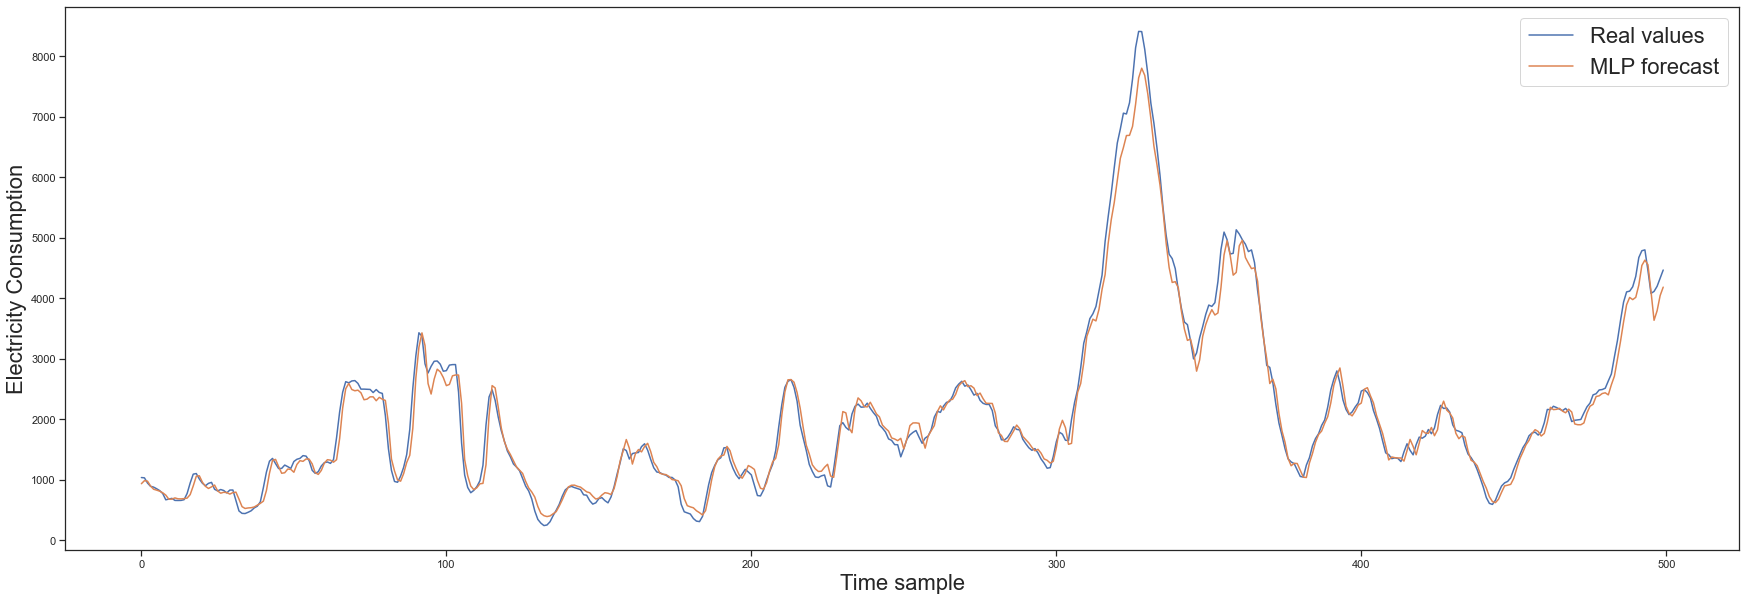

In [146]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(MLP_forecast[:500], label='MLP forecast')
ax.legend(prop={'size':22})
plt.show()

In [147]:
tf.keras.backend.clear_session()

lstm_learning = tf.keras.models.Sequential([
    LSTM(50, input_shape = input_shape, return_sequences=True),
    Flatten(),
    Dense(100, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
lstm_learning.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [148]:
Learning_Rate = lstm_learning.fit(train, epochs = 50, validation_data = val, callbacks = [lr_schedule])

Epoch 1/50
47/47 [==============================] - 1s 11ms/step - loss: 0.2218 - root_mean_squared_error: 0.3120 - val_loss: 0.1216 - val_root_mean_squared_error: 0.1358
Epoch 2/50
47/47 [==============================] - 0s 5ms/step - loss: 0.1658 - root_mean_squared_error: 0.2547 - val_loss: 0.1112 - val_root_mean_squared_error: 0.1125
Epoch 3/50
47/47 [==============================] - 0s 5ms/step - loss: 0.1301 - root_mean_squared_error: 0.1850 - val_loss: 0.1063 - val_root_mean_squared_error: 0.1153
Epoch 4/50
47/47 [==============================] - 0s 4ms/step - loss: 0.1069 - root_mean_squared_error: 0.1305 - val_loss: 0.0989 - val_root_mean_squared_error: 0.1115
Epoch 5/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0920 - root_mean_squared_error: 0.0966 - val_loss: 0.0840 - val_root_mean_squared_error: 0.0722
Epoch 6/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0816 - root_mean_squared_error: 0.0843 - val_loss: 0.0741 - val_root_mean_s

Epoch 49/50
47/47 [==============================] - 0s 4ms/step - loss: 9505533.0000 - root_mean_squared_error: 3080.6602 - val_loss: 413570.4688 - val_root_mean_squared_error: 628.5630
Epoch 50/50
47/47 [==============================] - 0s 4ms/step - loss: 11337841.0000 - root_mean_squared_error: 3364.1079 - val_loss: 412562.8125 - val_root_mean_squared_error: 625.1770


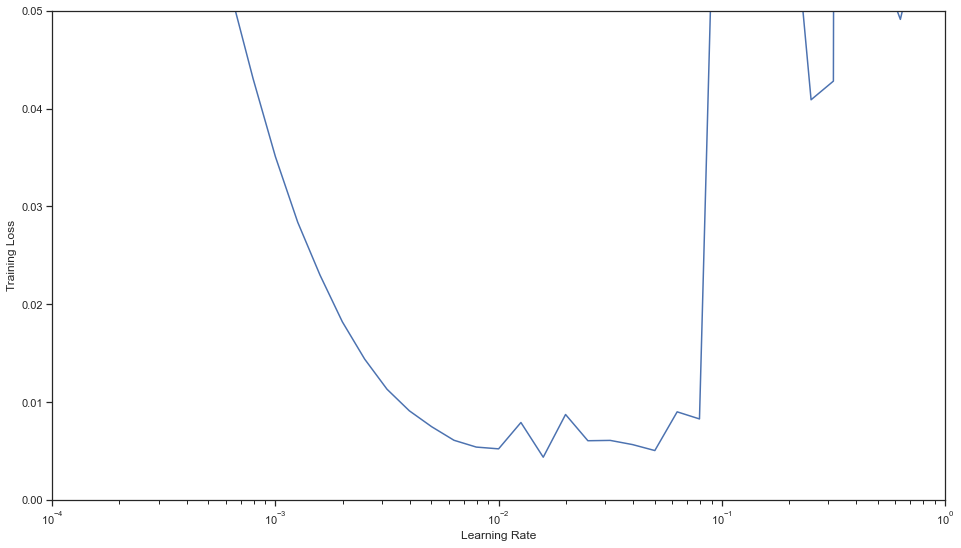

In [149]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [150]:
tf.keras.backend.clear_session()

LSTM = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, return_sequences = True),
    Flatten(),
    Dense(150, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = .001, amsgrad=True)
LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
LSTM_Model = LSTM.fit(train, epochs = 75, validation_data = val)  

Epoch 1/75
47/47 [==============================] - 1s 14ms/step - loss: 0.1735 - root_mean_squared_error: 255.2274 - val_loss: 0.1074 - val_root_mean_squared_error: 0.0960
Epoch 2/75
47/47 [==============================] - 0s 7ms/step - loss: 0.0821 - root_mean_squared_error: 0.0841 - val_loss: 0.0587 - val_root_mean_squared_error: 0.0547
Epoch 3/75
47/47 [==============================] - 0s 8ms/step - loss: 0.0489 - root_mean_squared_error: 0.0673 - val_loss: 0.0370 - val_root_mean_squared_error: 0.0485
Epoch 4/75
47/47 [==============================] - 0s 8ms/step - loss: 0.0327 - root_mean_squared_error: 0.0647 - val_loss: 0.0251 - val_root_mean_squared_error: 0.0451
Epoch 5/75
47/47 [==============================] - 0s 7ms/step - loss: 0.0232 - root_mean_squared_error: 0.0610 - val_loss: 0.0181 - val_root_mean_squared_error: 0.0449
Epoch 6/75
47/47 [==============================] - 0s 7ms/step - loss: 0.0170 - root_mean_squared_error: 0.0570 - val_loss: 0.0134 - val_root_mean

47/47 [==============================] - 0s 7ms/step - loss: 0.0029 - root_mean_squared_error: 0.0476 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0333
Epoch 49/75
47/47 [==============================] - 0s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0487 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0338
Epoch 50/75
47/47 [==============================] - 0s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0485 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0330
Epoch 51/75
47/47 [==============================] - 0s 7ms/step - loss: 0.0029 - root_mean_squared_error: 0.0478 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0328
Epoch 52/75
47/47 [==============================] - 0s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0483 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0325
Epoch 53/75
47/47 [==============================] - 0s 7ms/step - loss: 0.0029 - root_mean_squared_error: 0.0477 - val_loss: 0.0017 - val_root_mean_squared_

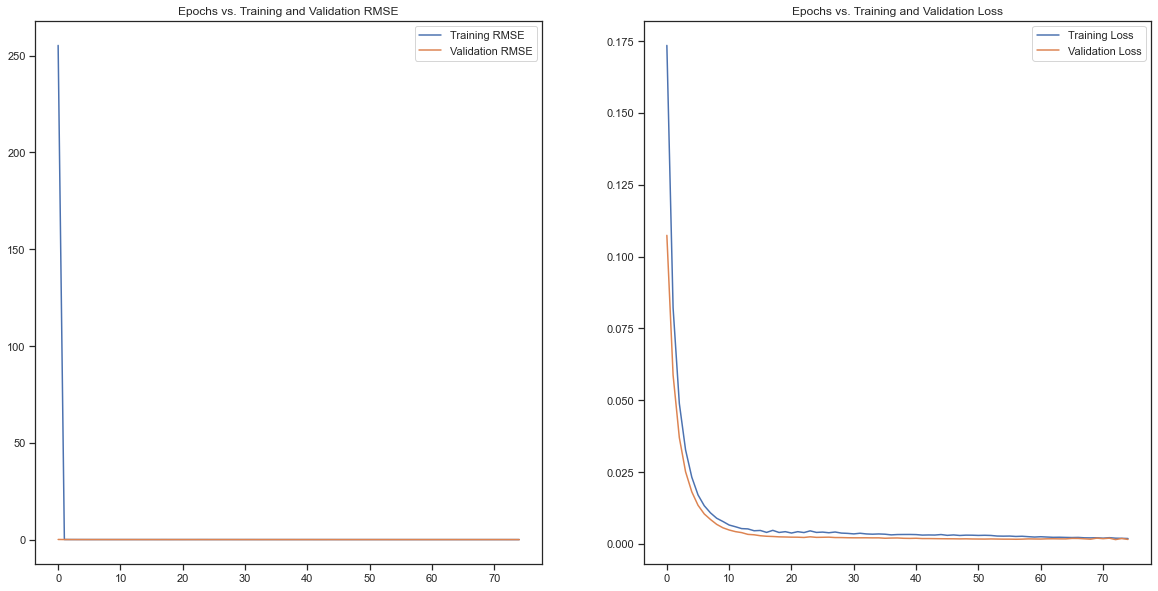

In [151]:
plot_model_rmse_and_loss(LSTM_Model)

In [152]:
forecast = LSTM.predict(X_test)
LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate LSTM forecast: 2758.176


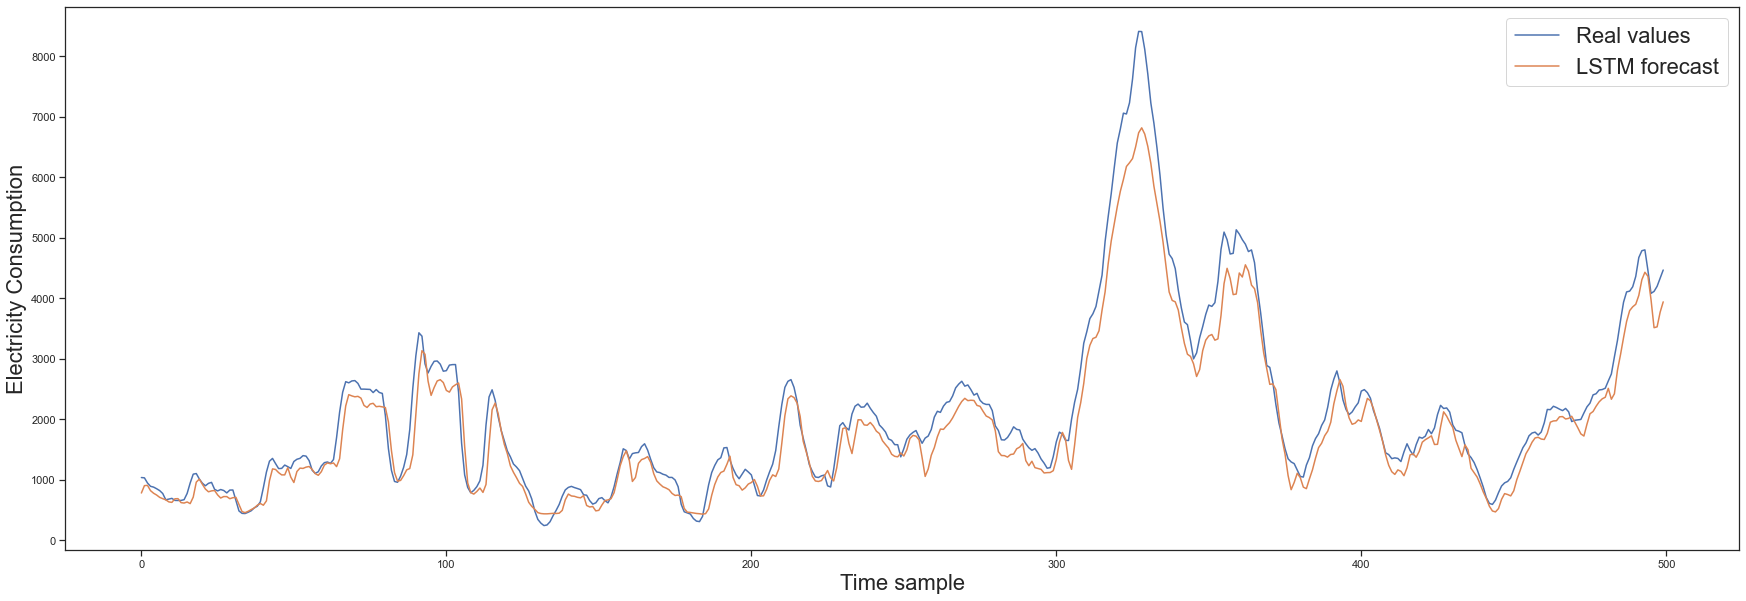

In [153]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(LSTM_forecast[:500], label='LSTM forecast')
ax.legend(prop={'size':22})
plt.show()

In [154]:
tf.keras.backend.clear_session()

cnn_lr = tf.keras.models.Sequential([ Conv1D(filters=50, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lr.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
47/47 [==============================] - 0s 4ms/step - loss: 0.0390 - root_mean_squared_error: 0.1808 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 2/50
47/47 [==============================] - 0s 1ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 4/50
47/47 [==============================] - 0s 1ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0652
Epoch 5/50
47/47 [==============================] - 0s 1ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 6/50
47/47 [==============================] - 0s 1ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0021 - val_root_mean_sq

Epoch 49/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1569 - root_mean_squared_error: 0.3961 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2150
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4206 - root_mean_squared_error: 0.6485 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1355


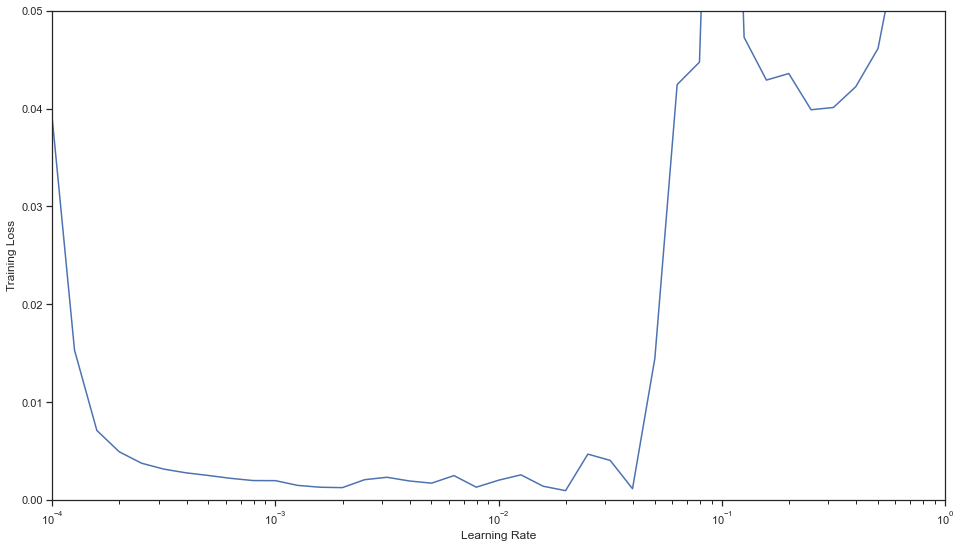

In [155]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [156]:
CNN = tf.keras.models.Sequential([Conv1D(filters = 75, kernel_size = 2, strides = 1, padding = 'causal',
                                         activation = 'relu', input_shape = input_shape),
                                  Flatten(),
                                  Dense(30, activation='relu'),
                                  Dense(1),
                                 ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_Model = CNN.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1337 - root_mean_squared_error: 0.3384 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0727 - root_mean_squared_error: 0.2696 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0398 - root_mean_squared_error: 0.1996 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0079 - val_root_m

47/47 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 49/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 50/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 51/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 52/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 53/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0013 - val_root_mean_squ

47/47 [==============================] - 0s 2ms/step - loss: 6.7077e-04 - root_mean_squared_error: 0.0259 - val_loss: 8.6287e-04 - val_root_mean_squared_error: 0.0294
Epoch 95/100
47/47 [==============================] - 0s 2ms/step - loss: 6.6699e-04 - root_mean_squared_error: 0.0258 - val_loss: 8.5763e-04 - val_root_mean_squared_error: 0.0293
Epoch 96/100
47/47 [==============================] - 0s 2ms/step - loss: 6.5787e-04 - root_mean_squared_error: 0.0256 - val_loss: 8.5387e-04 - val_root_mean_squared_error: 0.0292
Epoch 97/100
47/47 [==============================] - 0s 2ms/step - loss: 6.5475e-04 - root_mean_squared_error: 0.0256 - val_loss: 8.4131e-04 - val_root_mean_squared_error: 0.0290
Epoch 98/100
47/47 [==============================] - 0s 2ms/step - loss: 6.4764e-04 - root_mean_squared_error: 0.0254 - val_loss: 8.3805e-04 - val_root_mean_squared_error: 0.0289
Epoch 99/100
47/47 [==============================] - 0s 2ms/step - loss: 6.4156e-04 - root_mean_squared_error: 0

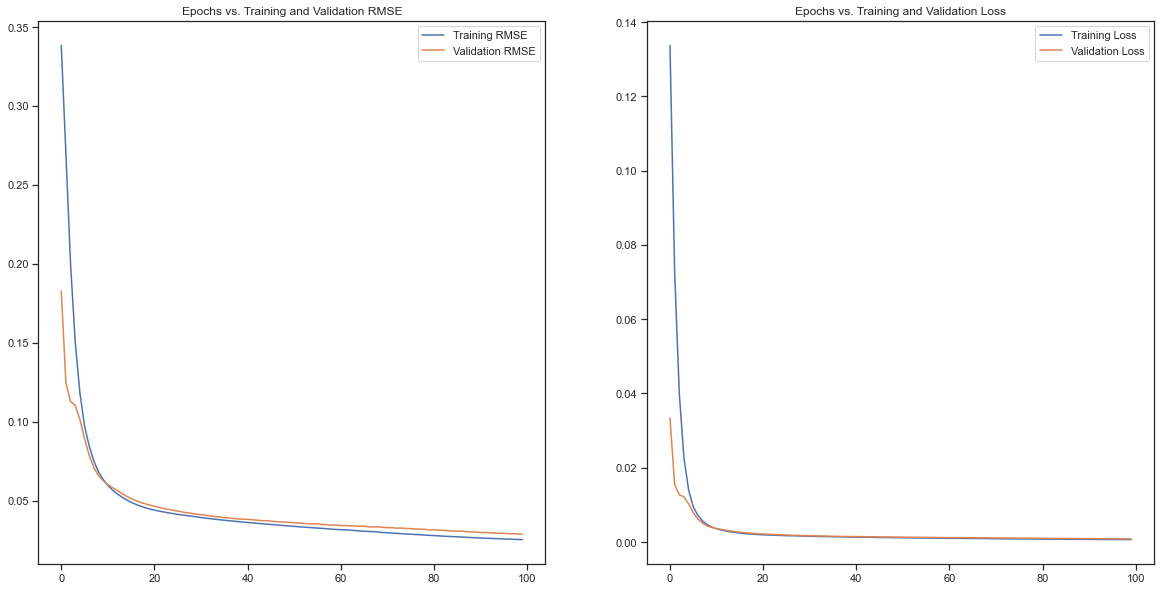

In [157]:
plot_model_rmse_and_loss(CNN_Model)

In [158]:
forecast =  CNN.predict(X_test)
CNN_forecast = scaler.inverse_transform(forecast)

rmse_CNN = sqrt(mean_squared_error(y_test, CNN_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}' .format(round(rmse_CNN, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 3128.102


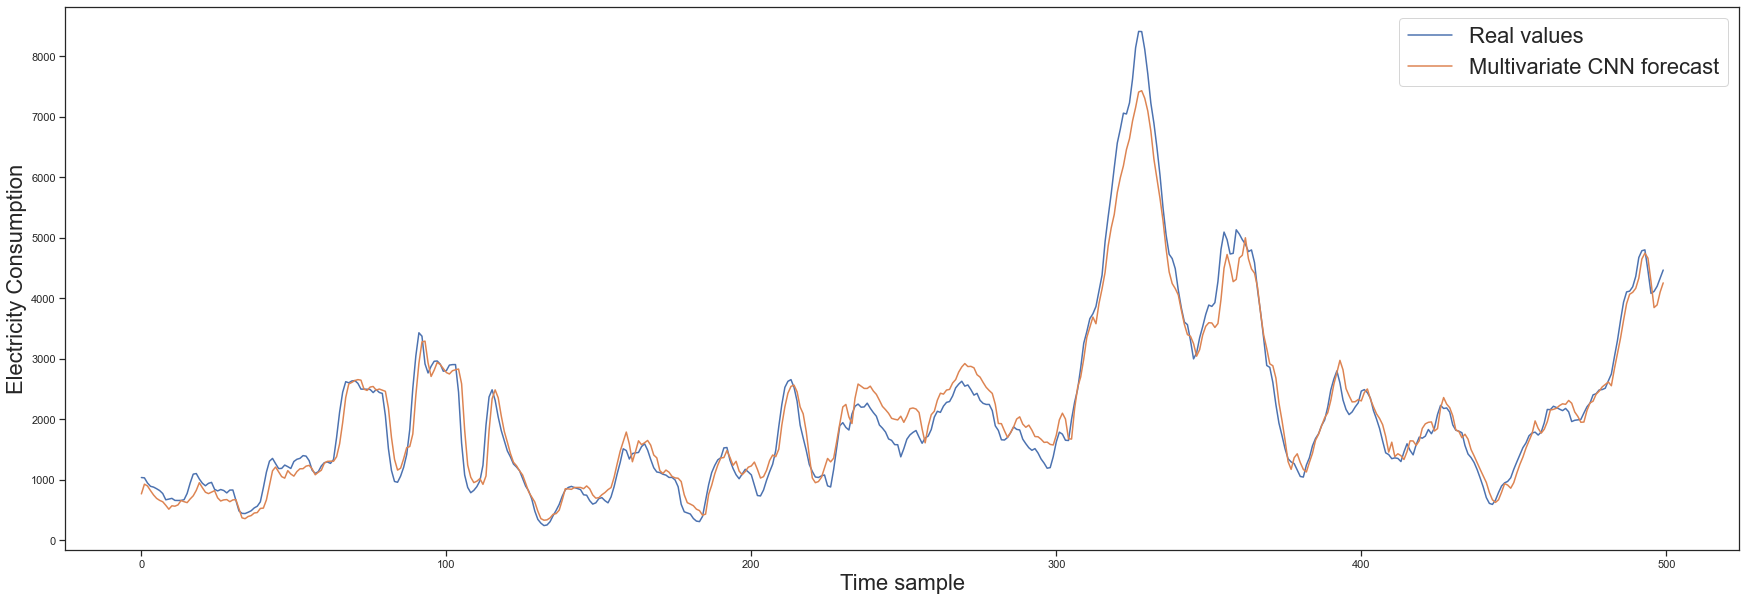

In [159]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(CNN_forecast[:500], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

In [162]:
tf.keras.backend.clear_session()

cnn_lstm = tf.keras.models.Sequential([ Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lstm.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
47/47 [==============================] - 1s 17ms/step - loss: 0.1060 - root_mean_squared_error: 0.2974 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1251
Epoch 2/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0610 - root_mean_squared_error: 0.2471 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 3/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1329
Epoch 4/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 6/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0041 - val_root_mea

Epoch 49/50
47/47 [==============================] - 0s 10ms/step - loss: 0.1457 - root_mean_squared_error: 0.3817 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2000
Epoch 50/50
47/47 [==============================] - 0s 9ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1388


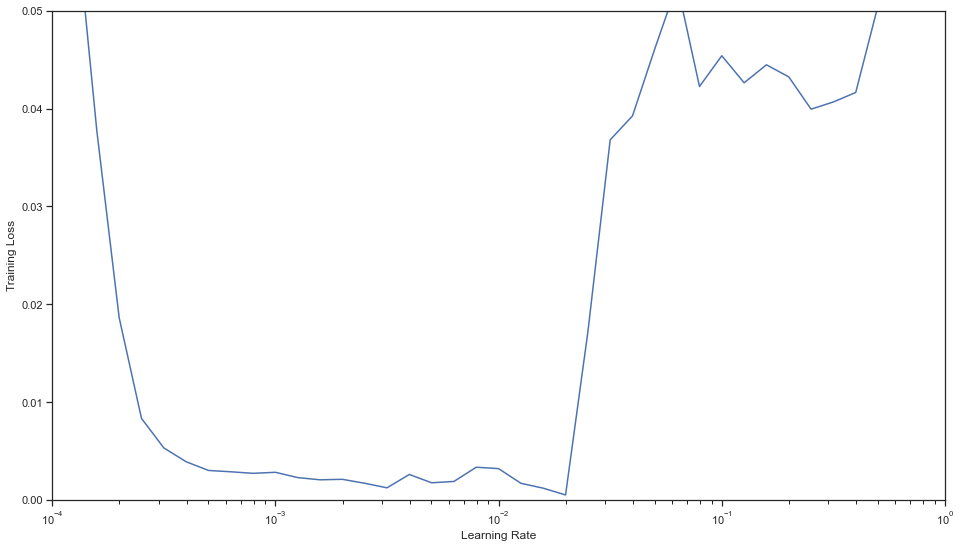

In [163]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [164]:
CNN_LSTM = tf.keras.models.Sequential([Conv1D(filters=100, kernel_size=2,strides=1, padding='causal',
                                              activation='relu', input_shape = input_shape),
                                       LSTM(50, return_sequences=True),
                                       Flatten(),
                                       Dense(30, activation='relu'),
                                       Dense(1) 
                                      ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN_LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_LSTM_Model = CNN_LSTM.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
47/47 [==============================] - 1s 13ms/step - loss: 0.1080 - root_mean_squared_error: 0.3052 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1592
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0673 - root_mean_squared_error: 0.2595 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1271
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0439 - root_mean_squared_error: 0.2096 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0109 - val_root_

Epoch 49/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 50/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 51/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 52/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 53/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 54/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0014 - val_

47/47 [==============================] - 0s 6ms/step - loss: 7.9006e-04 - root_mean_squared_error: 0.0281 - val_loss: 8.3316e-04 - val_root_mean_squared_error: 0.0289
Epoch 97/100
47/47 [==============================] - 0s 5ms/step - loss: 7.7717e-04 - root_mean_squared_error: 0.0279 - val_loss: 8.3996e-04 - val_root_mean_squared_error: 0.0290
Epoch 98/100
47/47 [==============================] - 0s 5ms/step - loss: 7.5628e-04 - root_mean_squared_error: 0.0275 - val_loss: 8.0477e-04 - val_root_mean_squared_error: 0.0284
Epoch 99/100
47/47 [==============================] - 0s 6ms/step - loss: 7.4253e-04 - root_mean_squared_error: 0.0272 - val_loss: 8.2986e-04 - val_root_mean_squared_error: 0.0288
Epoch 100/100
47/47 [==============================] - 0s 5ms/step - loss: 7.3175e-04 - root_mean_squared_error: 0.0271 - val_loss: 8.0429e-04 - val_root_mean_squared_error: 0.0284


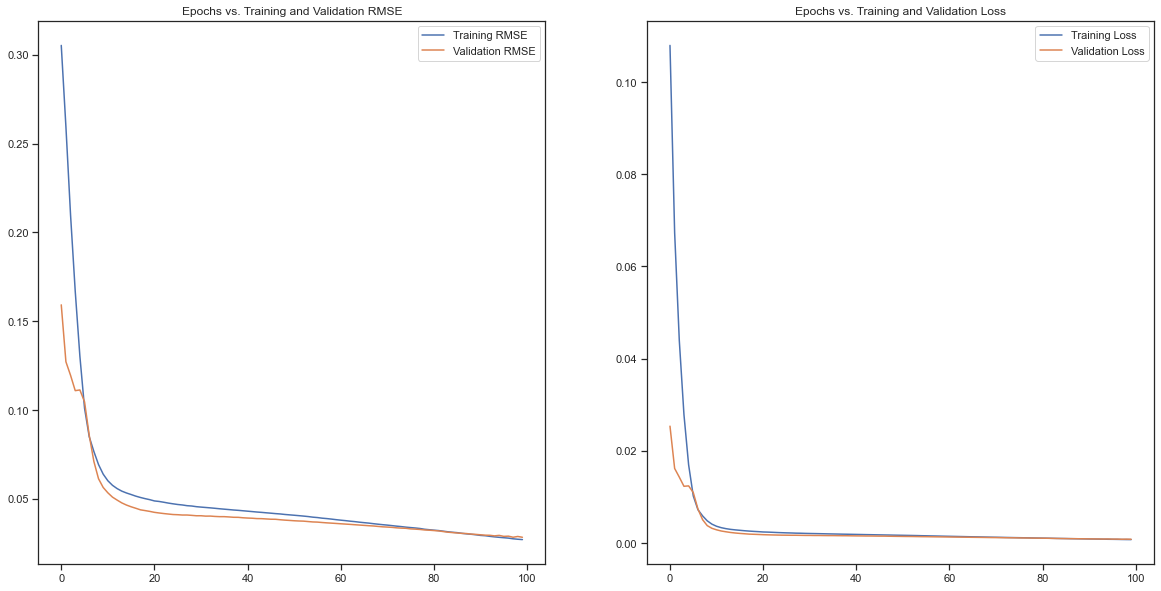

In [165]:
plot_model_rmse_and_loss(CNN_LSTM_Model)

In [166]:
forecast =  CNN_LSTM.predict(X_test)
CNN_LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, CNN_LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: 3613.498


In [167]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity price (€/MWhr)', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(CNN_LSTM_forecast[:500], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()